# Exercise 1: Optimize lepton selection

* First, print the distributions of the relevant variables for *all* the Monte Carlo samples (i.e. all the *channels* of the $Z$-boson decay to be studied). Which variables are these? Give sensible ranges to include all the events in the samples (both MC and OPAL data) 
* Do the same for **one** of the OPAL data samples (your lab assistant will decide which one you choose).
* Describe the results.
* Optimize the object selection by applying cuts. Make a strategy on how to proceed to find the optimal selection. which information do you need? in thin the
* Determine the efficiency and the amount of background for each $Z$ decay channel. Use the simulated events $e^+e^-$, $\mu^+\mu^-$, $\tau^+\tau^-$ and hadrons ($qq$). Represent the result in a matrix form and think carefully about how you have to correct the measured rates. Don't forget to calculate the errors!
* How do we estimate the statistical fluctuations per bin?

### Download missing libraries
Comment in the following two lines in case some of the libraries cannot be imported. Please restart the kernel after download+upgrade has successfully finished.

**Please comment in these lines when the libraries cannot be imported below**

In [59]:
### Download libraries
#%pip install uproot 
#%pip install awkward 
#%pip install mplhep 
#%pip install numpy 
#%pip install matplotlib 
#%pip install scipy

### Upgrade libraries to latest version
#%pip install uproot awkward mplhep numpy matplotlib scipy --upgrade

### Import libraries

In [1]:
import uproot
import awkward as ak
import mplhep
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
import csv

## Important Functions

In [27]:
#Defining data path
path_data = '/Users/sayed/OneDrive/Dokumente/GitHub/z0-precisionmeasurement/'

#fit functions

def lin(x,a,b):
    return a*x+b
def f(x,a,b):
    return a*(1+x**2)+b/(1-x)**2
def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
def breit_wigner(s,Mz,gamma_fe, gamma_z):
    s=s**2
    return 12*np.pi/Mz**2*(s*gamma_fe)/((s-Mz**2)**2+(s**2*gamma_z**2/Mz**2))
def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)
################################################################################
# testing functions

def ttest(x, sx, y, sy = 0):
    return np.abs(x - y)/np.sqrt(sx**2 + sy**2)


def redchi2(data,fit,sigma,n_param=2):
    return np.sum((((data-fit)/sigma))**2) / (len(data)-n_param)

############################################################################

#reading data function

def CSV(file):
    rows = []
    with open(file, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            rows.append(row)
    mean_energy=np.array(list(zip(*rows[1:]))[0], dtype=float)#*increment+start
    lumi=np.array(list(zip(*rows[1:]))[1], dtype=float)
    stat=np.array(list(zip(*rows[1:]))[2], dtype=float)
    sys=np.array(list(zip(*rows[1:]))[3], dtype=float)
    alll=np.array(list(zip(*rows[1:]))[4], dtype=float)
    return mean_energy, lumi,stat, sys, alll

###################################################################
#particle counting functions

def count_particles(p,N,E,HE): #for Grope data
    num_had=0
    num_muon=0
    num_e=0
    num_tau=0
    for i in range(0,len(N)):
        if N[i]>=10 and E[i]<=60 and E[i]>=20 and HE[i]>=5 and p[i]<=100:
            num_had+=1
            #print('hadron')
        elif N[i]<=15 and p[i]<=100 and E[i]>=60 and HE[i]<=5:
            num_e+=1
            #print('electron')
        elif p[i]>=50 and p[i]>=50 and p[i]<=120 and N[i]<=10 and E[i]<=7 and HE[i]<=25:
            num_muon+=1
            #print('muon')
        elif N[i]<=15 and p[i]<=100 and E[i]>=10 and E[i]<=60 and HE[i]<=40:
            num_tau+=1
            #print('tau')
    return np.array([num_had, num_muon, num_e, num_tau])



#for simulated data and opal data
def count_particles_simulated(p,N,E,HE, cos_thet): 
    num_had=0
    num_muon=0
    num_e=0
    cos_thet_e=[]
    e_s_channel=[]
    cos_thet_muon=[]
    num_tau=0
    for i in range(0,len(N)):
        if N[i]>=10:
            num_had+=1
        elif N[i]>=7 and E[i]<=82 and E[i]>=32 and HE[i]>=1 and p[i]<=85 and p[i]>=20 and p[i]/E[i]<=5:
            num_had+=1
            #print('hadron')
        #elif p[i]/E[i]>=20:
        #    num_muon+=1
        elif N[i]<=8 and p[i]<=75 and N[i]>=2 and E[i]<=65 and HE[i]<=22:# and p[i]/E[i]<=25:# and p[i]/HE[i]<=6:
            num_tau+=1
        elif p[i]>=65 and N[i]<=5 and N[i]>=1 and E[i]<=15.5 and HE[i]<=12:# and N[i]*E[i]<20 and p[i]*E[i]>50:
            num_muon+=1
            cos_thet_muon.append(cos_thet[i])
        elif N[i]<=8 and p[i]<=100 and E[i]>=65 and HE[i]<=5 and p[i]>=0:# and p[i]/E[i]<=3:# and N[i]*E[i]>10:
            num_e+=1
            cos_thet_e.append(cos_thet[i])
            if cos_thet[i]<=0 and cos_thet[i]>=-0.9:
                e_s_channel.append([p[i],N[i],E[i],HE[i],cos_thet[i]])
            #index=np.where((cos_thet_e<=0) & (cos_thet_e>=-0.9))
    return np.array([num_had, num_e, num_tau, num_muon]), cos_thet_e, cos_thet_muon,e_s_channel

#Note: The function count_particles_simulated was first determined by using defined cut limits, by variation by hand

#we also tried to obtain the cuts from the 3-sigma interval of gauss fits of the histograms
#for the simulated data. However this yields, not sufficiently good results and is therefore omitted.

# this is another way of counting the particles which will be compared to the upper one for the first part of the experiment
def particletest(N,Psum,E,HE):
    hadrons1=[]
    electrons1=[]
    tau1=[]
    muon1=[]
    
    hadrons1.append((np.where(N>=9,2,0))) ##
    hadrons1.append((np.where(N>=6.5,1,0)))##
    hadrons1.append((np.where(N>=15,20,0)))##
    hadrons1.append(np.where(Psum<=80,1,0)) ##
    hadrons1.append((np.where((E<=65) & (E>=45),0.5,0)))##
    hadrons1.append((np.where((E<=80) & (E>=30),1,0)))##
    hadrons1.append(np.where(HE>=20,1,0)) ##
    electrons1.append(np.where(HE<=20,1,0)) ##
    electrons1.append(np.where((HE>=0.2)&(HE<=1.5),0.75,0))##
    tau1.append(np.where(HE<=20,1,0)) ##
    muon1.append(np.where(HE<=20,1,0)) ##

    electrons1.append(np.where(N<=4.8,1,0)) ##
    electrons1.append(np.where(N<=1.5,2,0)) ##
    electrons1.append(np.where(Psum<=95,2.5,0)) ###
    electrons1.append(np.where(E>=65,1.25,0)) ##
    electrons1.append(np.where(E>=75,2,0)) ##
    electrons1.append(np.where(E>=85,9,0)) ##
    muon1.append(np.where(E<=15,1,0)) ##
    muon1.append(np.where(E<=9,1.5,0))#????  ##
    muon1.append(np.where((Psum>=70),1.5,0))
    muon1.append(np.where( (Psum>=80),1.5,0)) ##
    
    muon1.append(np.where((N<=4) &(N>=1),1.5,0)) ##
    
    tau1.append(np.where((N<=6.5) &(N>=1.5),1,0)) ##
    
    tau1.append(np.where(Psum <=75,0.25,0)) ##
    tau1.append(np.where(Psum <=70,0.5,0)) ##
    tau1.append(np.where(Psum <=65,0.75,0)) ##
    tau1.append(np.where(Psum <=60,1.5,0)) ##
    tau1.append(np.where(E<=70,0.5,0)) ##
    tau1.append(np.where((E<=25) &(E>=15),1,0)) ##
    
    hadrons1= np.sum(hadrons1, axis=0)
    electrons1= np.sum(electrons1, axis=0)
    tau1= np.sum(tau1, axis=0)
    muon1= np.sum(muon1, axis=0)
    
    maximal=np.amax([[hadrons1],[electrons1],[tau1],[muon1]], axis=0)

    hadron=np.sum(np.where(hadrons1>=maximal, 1,0))
    ele=np.sum(np.where(electrons1>=maximal, 1,0))
    tau=np.sum(np.where(tau1>=maximal, 1,0))
    muon=np.sum(np.where(muon1>=maximal, 1,0))
    
    return np.array([hadron, ele, tau,muon])

## Working with Grope data

In [3]:
#lists consisting of four lists including N_psum, N_char, E_ecal, E_hcal

hadron=np.array([[54.8,50.0,32.0,53.3,13.9,40.4,43.3,3.2,293.1,39.8,72.0,66.2,49.7,53.8,13.2,60.2,18.9,60.9,48.7,59.8],[52,28,24,36,28,39,21,30,22,34,39,20,25,25,53,30,37,23,27,9],[39.7,55.7,46.7,33.2,58.4,58.8,50.8,37.2,52.9,50.7,41.4,23.8,37.8,53.2,51.5,37.8,58.8,53.4,57.0,55.6], [15.8,11.9,8.3,16.3,5.5,0.6,203.9,3.3,15.7,13.5,25.0,15.9,48.7,17.7,6.0,84.6,9.0,28.4,9.5,23.3]])
electron=np.array([[0,84.4,92.2,0,78.5,83.8,0.0,0.0,71.0,0.0,71.6,71.3,74.4,0.0,83.2,47.9,65.1,82.5,0.0,0.0],[3,7,2,7,3,2,5,0,2,6,2,2,2,14,2,6,5,2,4,2],[92.0,89.1,89.5,67.9,90.3,93.5,75.3,84.1,91.6,95.3,92.2,94.2,88.5,83.8,91.2,90.3,92.5,90.3,91.1,90.1],[0.2,0.2,0.2,0.0,0.3,0.9,0.8,0.8,1.8,1.4,0.0,0.7,0.3,0.3,0.3,0.3,0.0,0.3,2.2,6.1]])
muon=np.array([[84.7,89.5,98.2,105.1,84.1,88.1,119.1,87.3,87.7,87.0,93.0,80.9,92.3,89.0,93.4,94.3,86.5,90.3,83.2,96.1],[6,2,2,2,2,2,2,4,2,2,2,2,4,2,2,7,2,2,2,2],[1.4,1.6,2.6,1.8,5.4,1.5,2.1,5.3,3.0,1.8,1.3,3.1,1.7,3.1,1.7,1.3,6.2,2.5,1.8,1.8],[2.4,13.4,9.9,6.6,13.8,3.5,6.2,30.3,9.3,10.0,2.6,4.7,5.5,5.3,1.8,3.9,44.7,18.8,4.9,10.7]])
tau=np.array([[43.8,31.4,43.0,37.6,55.0,33.9,0,44.7,2.0,67.0,99.3,45.8,0.0,30.4,41.1,26.9,64.6,44.9,25.0,29.8],[4,2,2,5,2,2,3,14,6,6,2,4,8,2,2,2,4,13,2,2],[8.2,36.1,31.7,43.0,49.7,52.0,31.1,35.7,90.8,45.0,16.6,40.1,70.8,21.7,40.6,51.8,29.8,37.5,44.9,36.5],[2.0,0.2,2.4,0.6,36.8,13.6,0.3,3.3,0.7,33.6,16.8,38.2,0,7.5,2.6,0.0,9.2,2.2,4.1,23.4]])

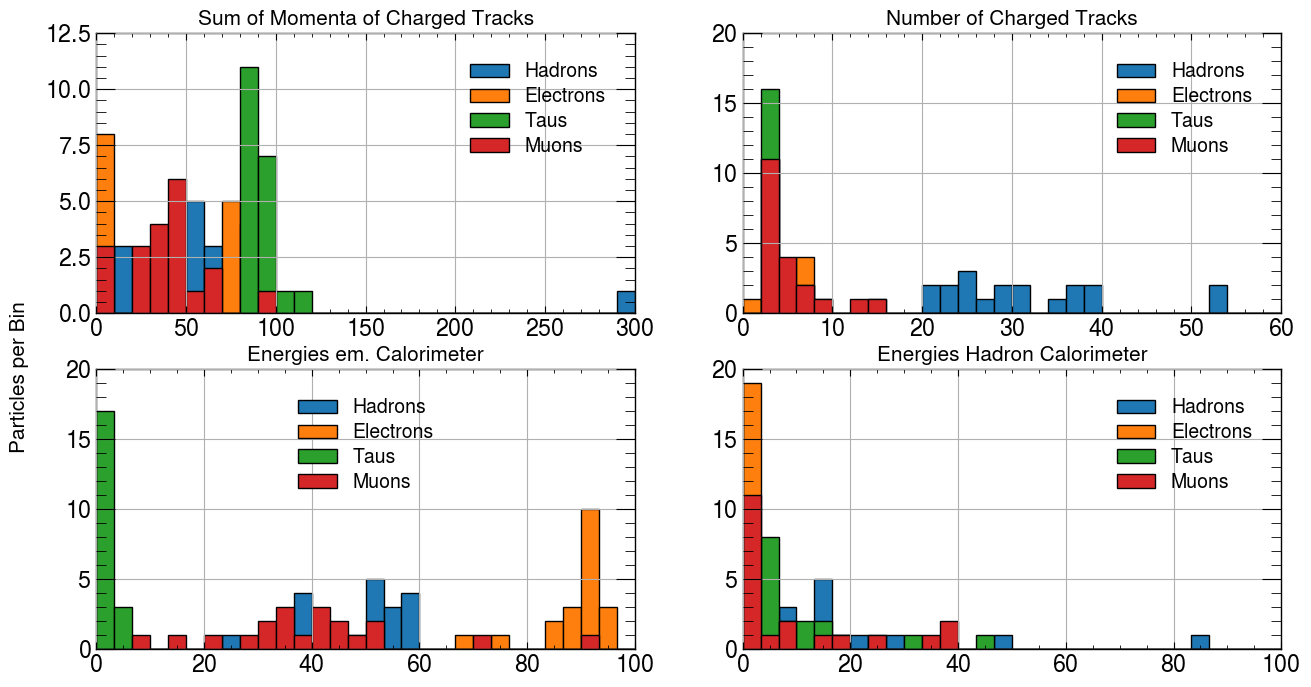

In [24]:
plt.style.use(mplhep.style.ATLAS)
fig, ax = plt.subplots(figsize = (15, 8))
title=['Sum of Momenta of Charged Tracks', 'Number of Charged Tracks', 'Energies em. Calorimeter', 'Energies Hadron Calorimeter']
label=['Hadrons', 'Electrons', 'Taus', 'Muons']
bins=[[15,8,3,10],[15,6,6,6],[10,10,2,15],[18,5,5,5]]
ranges=[(0,300),(0,60), (0,100), (0,100)]
#fig.text(0.55, 0.1, r'Center of Mass Energy [GeV]', ha='center', fontsize=15)
fig.text(0.1025, 0.5, r'Particles per Bin', va='center', rotation='vertical', fontsize=15)
for i in [0,1,2,3]: # 0=charged track sump, 1=charged track N, E
    plt.subplot(221+i)
    plt.title(title[i], fontsize=15)
    for j in [0,1,2,3]:
        particle=[hadron[i], electron[i],muon[i],tau[i]]
        plt.hist(particle[j], bins=30, label=label[j],range=ranges[i], edgecolor='black',alpha=1)
    plt.grid()
    plt.legend()


In [26]:
###testing the cuts for Grope data

p=np.concatenate((hadron[0], electron[0], muon[0], tau[0]))
N=np.concatenate((hadron[1], electron[1], muon[1], tau[1]))
E=np.concatenate((hadron[2], electron[2], muon[2], tau[2]))
HE=np.concatenate((hadron[3], electron[3], muon[3], tau[3]))


cp=count_particles(p,N,E,HE)
print('numbers of hadrons, electron, taus, muons:',cp)

numbers of hadrons, electron, taus, muons: [16 18 21 18]


# Evaluating data obtained by Monte Carlo simulation

In the frist part of the expoeriment we will investigate some simulations of Data sets with particles of known origin.

We will open data and Monte Carlo samples using **uproot**. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

You can find more info on uproot following the references:
* Github repo: https://github.com/scikit-hep/uproot4
* Tutorial: https://masonproffitt.github.io/uproot-tutorial/
* Video tutorial on uproot and awkward arrays:  https://www.youtube.com/embed/ea-zYLQBS4U 

First, let's specify the folder path for both data and Monte Carlo (MC) samples

## Procedure
In this section we want to get a rough estimate of how our counting algorithm works. Therefore we use the function we generated above for our cutting, to get a rough estimate of how many particles are actually counted wrong.

In the below discussion we did not include any errors, which we will get through the Poisson distribution.

Based on the new Histogramms, whcih are shown in the end of the chapter, we will define new cutting regions for our particles. We do poisson fits and then include alle data in a 3-sigma intervall. 

It turned out that the results provided by this method for the intervals, where to det the cuts is more bad, than just estimating by hand and screwing a bit with the parameters of the fit itself.

## Reading simulated data and creating efficiency matrix 

In [28]:
#matrix obtained using counting function 1
matrix=[]
error_matrix=[]
# matrix obtained using counting function 2
matrix2=[]
error_matrix2=[]

#list of criterias for each particle type (Nchar, ....)
criteria=[]


for i in ['qq.root','ee.root', 'tt.root','mm.root']:
    ### Open the file introducing file path
    file = uproot.open(path_data+i)
    ttree_name = 'myTTree'

    ### Print list of 'branches' of the TTree (i.e. list of variable names)
    file[ttree_name].keys()
    #print(file[ttree_name].keys())

    ## Load branches
    branches = file[ttree_name].arrays()

    ## Define an numpy array for 'Pcharged'
    Pcharged = 'Pcharged'
    NCharged='Ncharged'
    E_ecal='E_ecal'
    E_hcal='E_hcal'
    cos_thet='cos_thet'
    E_lep='E_lep'
    

    pchar = ak.to_numpy(branches[Pcharged]) # See Docu (https://awkward-array.org/how-to-convert-numpy.html) for more conversions
    Nchar = ak.to_numpy(branches[NCharged])
    E_ecal = ak.to_numpy(branches[E_ecal])
    E_hcal = ak.to_numpy(branches[E_hcal])
    cos_thet =ak.to_numpy(branches[cos_thet])
    E_lep = ak.to_numpy(branches[E_lep])
    
    criteria.append([pchar, Nchar, E_ecal, E_hcal, cos_thet,E_lep])
    
    cp,ph1,ph2,ph3=count_particles_simulated(pchar,Nchar,E_ecal,E_hcal,cos_thet) #ph= placeholder
    
    #inserting counted particle number divided through total particle number into the matrix
    matrix.append(cp/len(Nchar))
    
    error_matrix.append(np.sqrt(cp/len(Nchar)**2+cp**2/len(Nchar)**3))
    
    listen=np.array(np.full(4,0))
    cp=particletest(Nchar,pchar,E_ecal,E_hcal)
    matrix2.append(cp/len(Nchar))
    error_matrix2.append(np.sqrt(cp/len(Nchar)**2+cp**2/len(Nchar)**3))
    

matrix=np.array(matrix)
matrix2=np.array(matrix2)
error_matrix=np.array(error_matrix)   
error_matrix2=np.array(error_matrix2)


print('Efficiency matrix:')
print(matrix)
print('Error efficiency matrix:')
print(error_matrix)
print('Efficiency matrix 2:')
print(matrix2)
print('Error efficiency matrix 2:')
print(error_matrix2)

Efficiency matrix:
[[9.81412903e-01 6.29039295e-04 5.81354058e-03 0.00000000e+00]
 [0.00000000e+00 9.41664357e-01 4.75469606e-03 0.00000000e+00]
 [7.48605045e-03 1.81912288e-02 8.95927488e-01 5.04961244e-04]
 [0.00000000e+00 0.00000000e+00 8.39469809e-02 8.76521758e-01]]
Error efficiency matrix:
[[3.27996993e-03 7.99131927e-05 2.43569069e-04 0.00000000e+00]
 [0.00000000e+00 3.01403536e-03 2.25675988e-04 0.00000000e+00]
 [3.08563764e-04 4.83553713e-04 3.57806495e-03 7.98615390e-05]
 [0.00000000e+00 0.00000000e+00 9.81893248e-04 2.68515650e-03]]
Efficiency matrix 2:
[[9.72677374e-01 1.46200907e-02 1.29054513e-02 1.28851597e-03]
 [1.06607535e-05 9.91929810e-01 3.90183578e-03 4.16835462e-03]
 [6.04691090e-03 7.52266014e-02 9.05900472e-01 1.50099730e-02]
 [0.00000000e+00 3.37461989e-02 5.72996684e-02 9.08985919e-01]]
Error efficiency matrix 2:
[[3.23981250e-03 3.87944684e-04 3.64178327e-04 1.14410943e-04]
 [1.06608103e-05 3.26441836e-03 2.04349730e-04 2.11241647e-04]
 [2.77124504e-04 1.0104

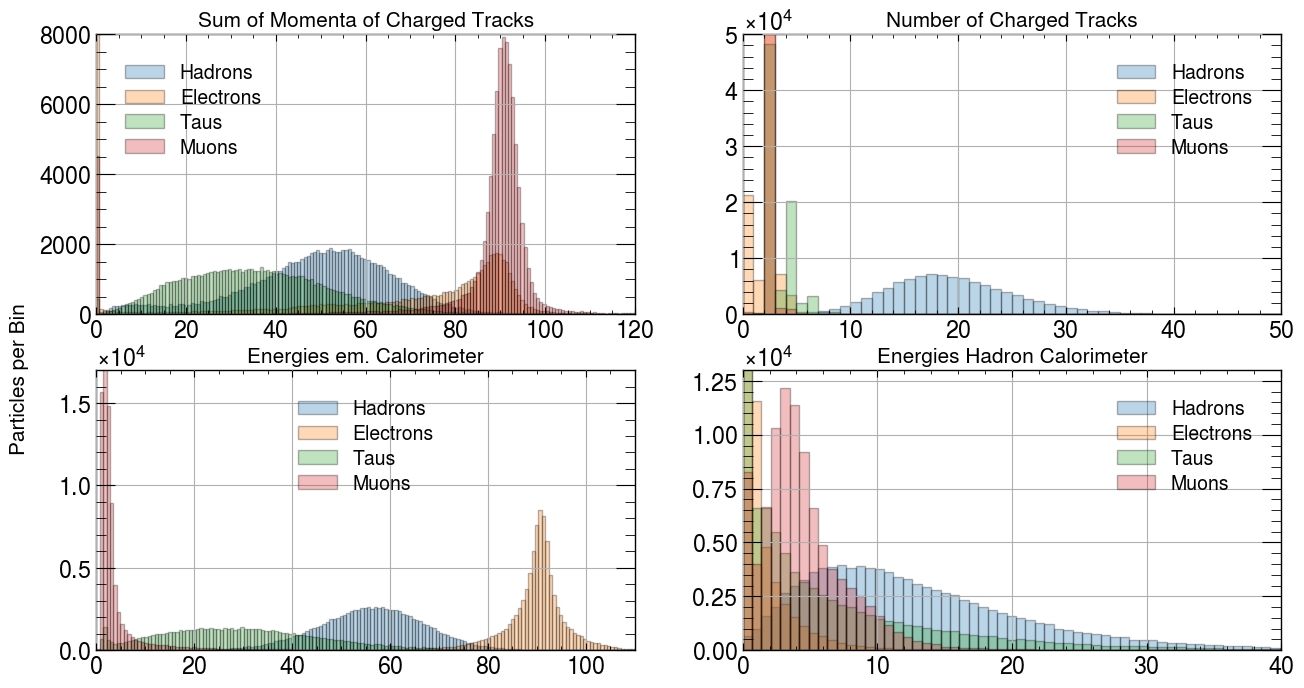

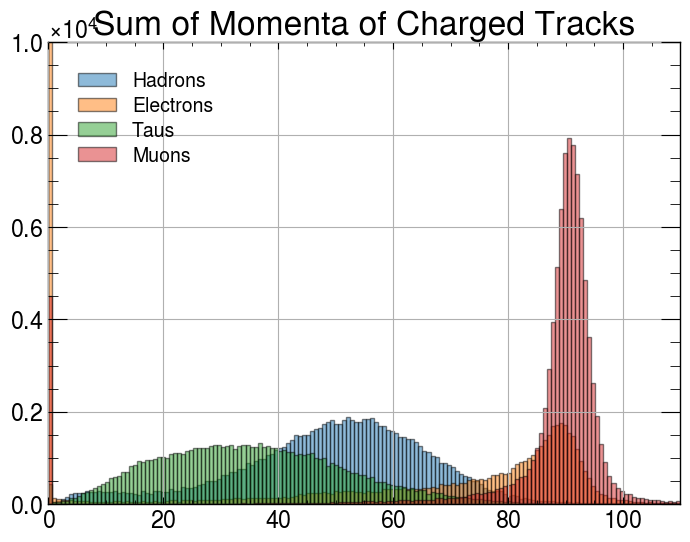

In [37]:
fig, ax = plt.subplots(figsize = (15, 8))
title=['Sum of Momenta of Charged Tracks', 'Number of Charged Tracks', 'Energies em. Calorimeter', 'Energies Hadron Calorimeter']
label=['Hadrons', 'Electrons', 'Taus', 'Muons']
xlim=[(0,120),(0,50), (0,110), (0,40)]
ylim=[(0,0.8e4),(0,0.5e5),(0,1.7e4),(0,1.3e4)]
#fig.text(0.55, 0.1, r'Center of Mass Energy [GeV]', ha='center', fontsize=15)
fig.text(0.1025, 0.5, r'Particles per Bin', va='center', rotation='vertical', fontsize=15)
bins=[200,140,200,200]

for i in [0,1,2,3]:
    plt.subplot(221+i)
    plt.title(title[i], fontsize=15)
    for j in [0,1,2,3]:
        particle=[criteria[0][i], criteria[1][i],criteria[2][i],criteria[3][i]]
        entries, bin_edges, patches=plt.hist(particle[j], bins=bins[i],range=(0.,140.), label=label[j], edgecolor='black',alpha=0.3)
        plt.xlim(xlim[i])
        plt.ylim(ylim[i])
    plt.legend()
    plt.grid()
    
    

for i in [0]:
    plt.figure()
    plt.title(title[i])
    for j in [0,1,2,3]:
        particle=[criteria[0][i], criteria[1][i],criteria[2][i],criteria[3][i]]
        entries, bin_edges, patches=plt.hist(particle[j],bins=200,range=(0.,140.), edgecolor='black', label=label[j],alpha=0.5)
        plt.ylim(0,1e4)
        plt.xlim(0,110)
    plt.legend()
    plt.grid()

___________________________________________________________________________________________________________________
Die fitparameter der Gaußfunktion des Histograms hadron mit zugehörigen Fehlern lauten: $A=(1842.377 \pm 5.839)$
$\mu=(56.576 \pm 0.039)$
$\sigma=(10.619 \pm 0.039)$
Als Cutting bereich für E_Ecal für hadron wählen wir die Bereiche: 24.719055486081622 88.43234954754001
___________________________________________________________________________________________________________________
___________________________________________________________________________________________________________________
Die fitparameter der Gaußfunktion des Histograms electron mit zugehörigen Fehlern lauten: $A=(5179.185 \pm 102.303)$
$\mu=(90.559 \pm 0.065)$
$\sigma=(2.862 \pm 0.065)$
Als Cutting bereich für E_Ecal für electron wählen wir die Bereiche: 81.9727682090662 99.14484570203166
_____________________________________________________________________________________________________________

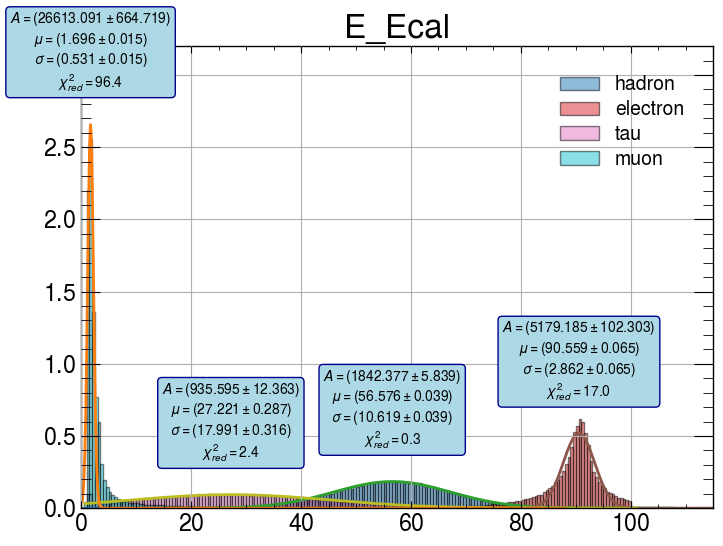

In [70]:
poptp0Ecal=([(0.3e4,55,20),(0.7e4,90,10),(0.1e4,35,40),(0,30,30)])
KäsefürFehler=30
for i in [2]:
    plt.figure()
    plt.title(title[i])
    for j in [0,1,2,3]:
        particle=[criteria[0][i], criteria[1][i],criteria[2][i],criteria[3][i]]
        entries, bin_edges, patches=plt.hist(particle[j], bins=200,range=(0,100), label=label[j], edgecolor='black',alpha=0.5)
        x=np.linspace(min(particle[j]),max(particle[j]),600)
        bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        popt, pcov = curve_fit(gauss, bin_middles, entries,p0=poptp0Ecal[j],maxfev=10000)
        #popt2, pcov2=curve_fit(fit_function, bin_middles, entries, maxfev=1000000)         
        plt.plot(x,fit_function(x,*popt2))
        plt.plot(x,gauss(x,*popt))
        print('___________________________________________________________________________________________________________________')
        print('Die fitparameter der Gaußfunktion des Histograms', label[j],'mit zugehörigen Fehlern lauten:','\n'.join((
        r'$A=(%.3f \pm %.3f)$' % (popt[0],np.sqrt(pcov[0][0]), ),
        r'$\mu=(%.3f \pm %.3f)$' % (popt[1],np.sqrt(pcov[1][1]), ),
        r'$\sigma=(%.3f \pm %.3f)$' % (popt[2],np.sqrt(pcov[2][2]), ),)))
        print('Als Cutting bereich für', title[i],'für', label[j],'wählen wir die Bereiche:',popt[1]-3*abs(popt[2]),popt[1]+3*abs(popt[2]))
        print('___________________________________________________________________________________________________________________')
        redchi=redchi2(entries,gauss(bin_middles,*popt),np.sqrt(entries)+KäsefürFehler,3)


        textstr = '\n'.join((
            r'$A=(%.3f \pm %.3f)$' % (popt[0],np.sqrt(pcov[0][0]), ),
            r'$\mu=(%.3f \pm %.3f)$' % (popt[1],np.sqrt(pcov[1][1]), ),
            r'$\sigma=(%.3f \pm %.3f)$' % (popt[2],np.sqrt(pcov[2][2]), ),
            r'$\chi^2_{red}=%.1f$' % (redchi, )))

        plt.text(popt[1], popt[0]+0.5e4, textstr, size=10,ha="center",
            va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')
        
        plt.xlim(0,115)
        plt.ylim(0,3.2e4)
    plt.legend()
    plt.grid()

### Below Examplary Plot of a Histogram for other Parameters
One sees, that this method is rather not the one, we should use in the following to set up our cuts! Therefore we will just, screw with the parameters by hand and by this method try to obtimize the matrix.

Okay For the Parameter below only the Momentum of the electron goes wrong.

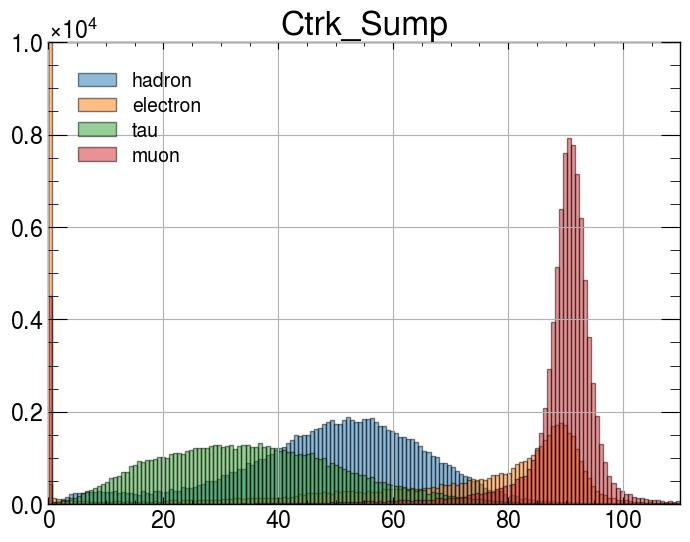

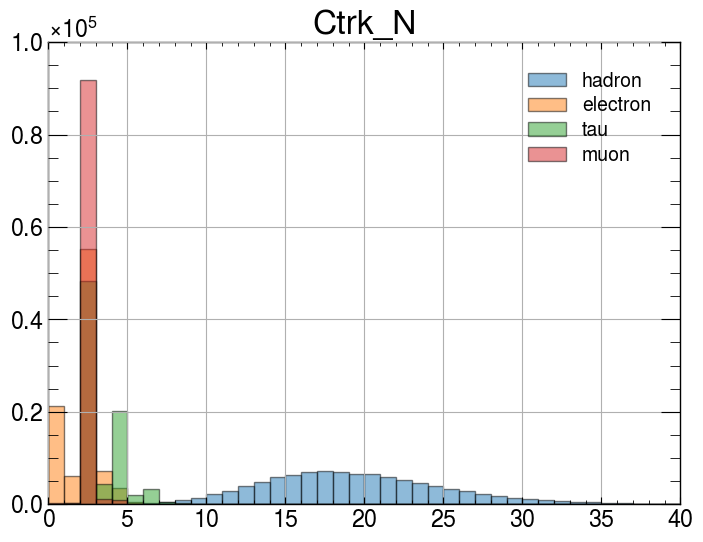

In [72]:
title=['Ctrk_Sump', 'Ctrk_N', 'E_Ecal', 'E_Hcal']
label=['hadron', 'electron', 'tau', 'muon']
bins=[[150,800,300,100],[150,600000,600,600],[100,100,200,150],[180,50,500,500]]
poptp0Pcharged=([(0,20,20),(0,80,0),(0,60,40),(0,30,30)])
for i in [1]:
    plt.figure()
    plt.title(title[i])
    for j in [0,1,2,3]:
        particle=[criteria[0][i], criteria[1][i],criteria[2][i],criteria[3][i]]
        entries, bin_edges, patches=plt.hist(particle[j],bins=40,range=(0.,40.), edgecolor='black', label=label[j],alpha=0.5)
        plt.xlim(0,40)
    plt.legend()
    plt.grid()

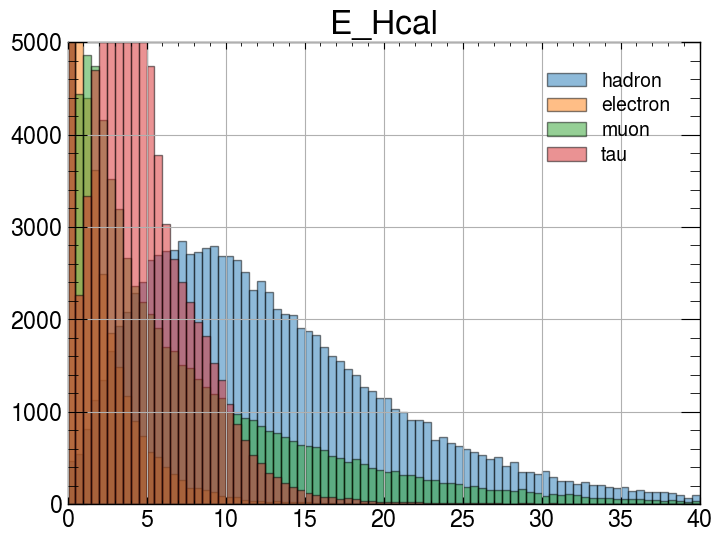

In [73]:
title=['Ctrk_Sump', 'Ctrk_N', 'E_Ecal', 'E_Hcal']
label=['hadron', 'electron', 'muon', 'tau']
bins=[[150,800,300,100],[150,600000,600,600],[100,100,200,150],[180,50,500,500]]
poptp0Pcharged=([(0,20,20),(0,80,0),(0,60,40),(0,30,30)])
for i in [3]:
    plt.figure()
    plt.title(title[i])
    for j in [0,1,2,3]:
        particle=[criteria[0][i], criteria[1][i],criteria[2][i],criteria[3][i]]
        entries, bin_edges, patches=plt.hist(particle[j],bins=100,range=(0.,50.), edgecolor='black', label=label[j],alpha=0.5)
        plt.legend()
    plt.xlim(0,40)
    plt.ylim(0,0.5e4)
    plt.grid()

# 1.1 Determination of Cuts by Hand

The last line shows all the variables available in the TTree to carry out the experiment. The meaning of these is described in the following table

| Variable name | Description |
| --- | --- | 
| <pre>run</pre> | Run number |
| <pre>event</pre> | Event number |
| <pre>Ncharged</pre> | Number of charged tracks |
| <pre>Pcharged</pre> | Total scalar sum of track momenta |
| <pre>E_ecal</pre> | Total energy measured in the electromagnetic calorimeter |
| <pre>E_hcal</pre> | Total energy measured in the hadronic calorimete |
| <pre>E_lep</pre> | LEP beam energy (=$\sqrt{s}/2$) |
| <pre>cos_thru</pre> | cosine of the polar angle between beam axis and thrust axis |
| <pre>cos_thet</pre> | cosine of the polar angle between incoming positron and outgoing positive particle |

We proceed to plot *PCharged* for illustration.

You can find all features provided by the function *matplotlib.pyplot.hist()* in the **matplotlib documentation**: https://matplotlib.org/3.3.1/api/_as_gen/matplotlib.pyplot.hist.html

### Apply a cut

Cuts are applied by *masking* the array. This can be done as follows:

In [74]:
## Create a mask for certain selection
mymask = branches['Pcharged'] >= 18.4
#print(mymask)

## The sum of this array provides the number of events that passed this cut
print(f"A total of '{sum(mymask)}' out of '{len(mymask)}' events passed the cut 'mymask'")

A total of '89809' out of '94381' events passed the cut 'mymask'


### Some useful information about your selection

In [75]:
print(f"Mean of {var}: ({pchar.mean()}) {np.nanmean(pchar)}")
print(f"Standard deviation of {var}: ({pchar.std()}) {np.nanstd(pchar)}")
print(f"Minimum value of {var}: ({pchar.min()}) {np.nanmin(pchar)}")
print(f"Maximum value of {var}: ({pchar.max()}) {np.nanmax(pchar)}")

Mean of Pcharged: (88.13310241699219) 88.13310241699219
Standard deviation of Pcharged: (256.1211242675781) 256.1211242675781
Minimum value of Pcharged: (0.0) 0.0
Maximum value of Pcharged: (73101.0546875) 73101.0546875


### Make a plot with a certain selection

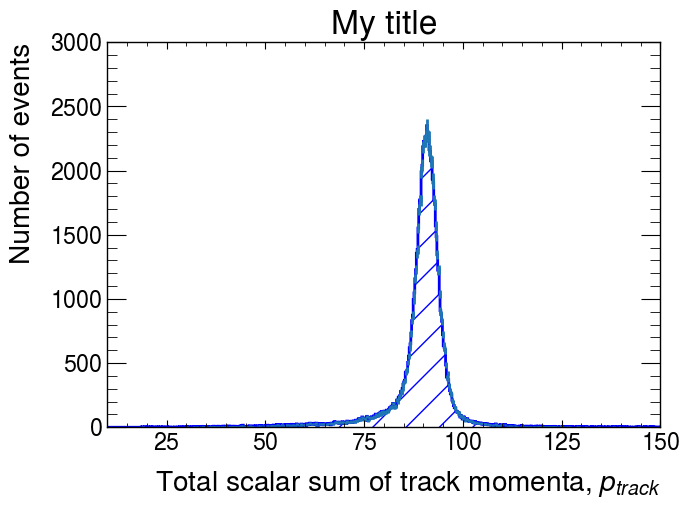

In [76]:
plt.style.use(mplhep.style.ATLAS) # You can load ATLAS/CMS/ALICE plot style 
plt.figure(figsize=(7,5))

bin_content, bin_edges, _ = plt.hist(pchar[mymask],bins=1000,range=(0.,200.), histtype='step',  linewidth=2, edgecolor='b', hatch='/', label='Pcharged')
mid = 0.5*(bin_edges[1:] + bin_edges[:-1]) #Calculate midpoint of the bars

error_sizes = np.sqrt(bin_content)

plt.errorbar(mid, bin_content, yerr=error_sizes, fmt='none')
### When producing an histogram, you can store the bin content and the edges of the bins in 
###'bin_content', and 'bin_edges' 
#print(bin_content)
#print(bin_edges)

### Show the plot on screen
plt.title('My title')
plt.xlim(10.,150.)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')
plt.show()

### Statistical uncertainties to the histogram

Think about the statistical uncertainties computed above in 'error_sizes'. 
* **Are these sensible? Why do we use this formula?** (Hint: Making an histogram is, in short, a *counting experiment*. In the limit of large total number of events, the (binomial) probability function limits to the *Poisson distribution*. What is the variance? And the standard deviation?)

### *Example*: How to fit a distribution

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

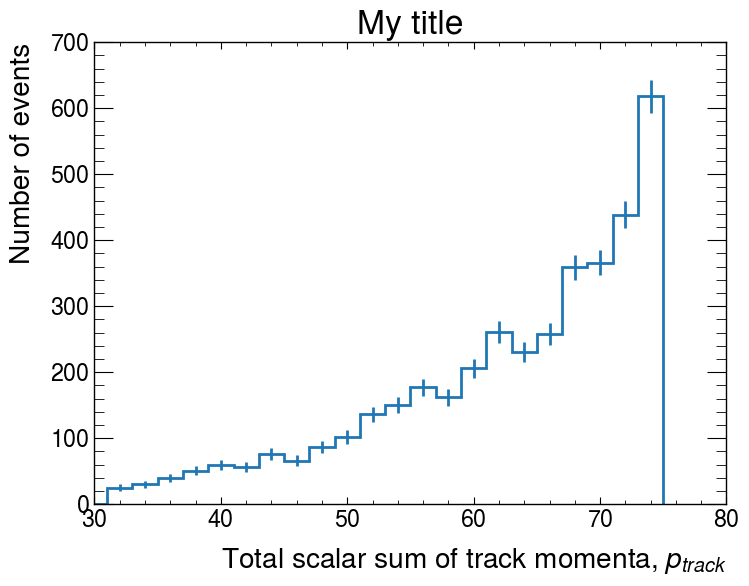

In [77]:
from scipy.optimize import curve_fit

mynewmask = branches['Pcharged'] >= 31.23

# Plot data with statistical uncertainties
new_bin_content, new_bin_edges, _ = plt.hist(pchar[mynewmask],bins=25,range=(25.,75.),  histtype='step', linewidth=2, label='Pcharged')
new_mid = 0.5*(new_bin_edges[1:] + new_bin_edges[:-1]) #Calculate midpoint of the bars
new_error_sizes = np.sqrt(new_bin_content)

plt.errorbar(new_mid, new_bin_content, yerr=new_error_sizes, fmt='none')

### Show the plot on screen
plt.title('My title')
plt.xlim(30.,80.)
plt.xlabel('Total scalar sum of track momenta, $p_{track}$')
plt.ylabel('Number of events')


# Define model function to be used to fit to the data above:


# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [321., 50., 32.]

## Fit curve (WARNING: The fit does not propagate bin uncertainties to the uncertainties of the fit parameters!)
coeff, var_matrix = curve_fit(gauss, new_mid, new_bin_content, p0=p0)

# Get the fitted curve
hist_fit = gauss(new_mid, *coeff)

plt.plot(new_mid, hist_fit, label='Fit')

plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=%.3f,\ \sigma=%.3f$' %(coeff[1], abs(coeff[2])))

plt.show()

### Matrix Inversion
To determine the uncertainties of the matrix elements after the inversion we use Monte Carlo toy experiments. In this context, what are the advantages and disadvantages of this method when compared to analytical expressions? Discuss it briefly.

**References**:
* Propagation of Errors for Matrix Inversion: https://arxiv.org/abs/hep-ex/9909031v1

In [ ]:
### Number of toy experiments to be done
ntoy = 1000

### Create numpy matrix of list to append elements of inverted toy matrices
inverse_toys = np.empty((4,4))

# Create toy efficiency matrix out of gaussian-distributed random values
for i in range(0,ntoy,1):
    toy_matrix = np.zeros((4,4))
    #np.random.seed(2)
    toy_matrix = np.random.normal(matrix,error_matrix,size=(4,4))
    
    ### Invert toy matrix
    inverse_toy = np.linalg.inv(toy_matrix)
    
    #print(inverse_toys.item(0,0),inverse_toy.item(0,0))
    # Append values
    
    inverse_toys = np.dstack((inverse_toys,inverse_toy))

Erros for the inverse matrix:
[[4.55500188e-03 9.22185542e-05 2.90170760e-04 6.87516523e-07]
 [2.67381041e-06 5.15913489e-03 2.63576244e-04 5.69119271e-07]
 [3.51557179e-04 5.95262262e-04 5.73035042e-03 1.13281975e-04]
 [3.49456111e-05 6.28873572e-05 1.39317910e-03 5.57067197e-03]]


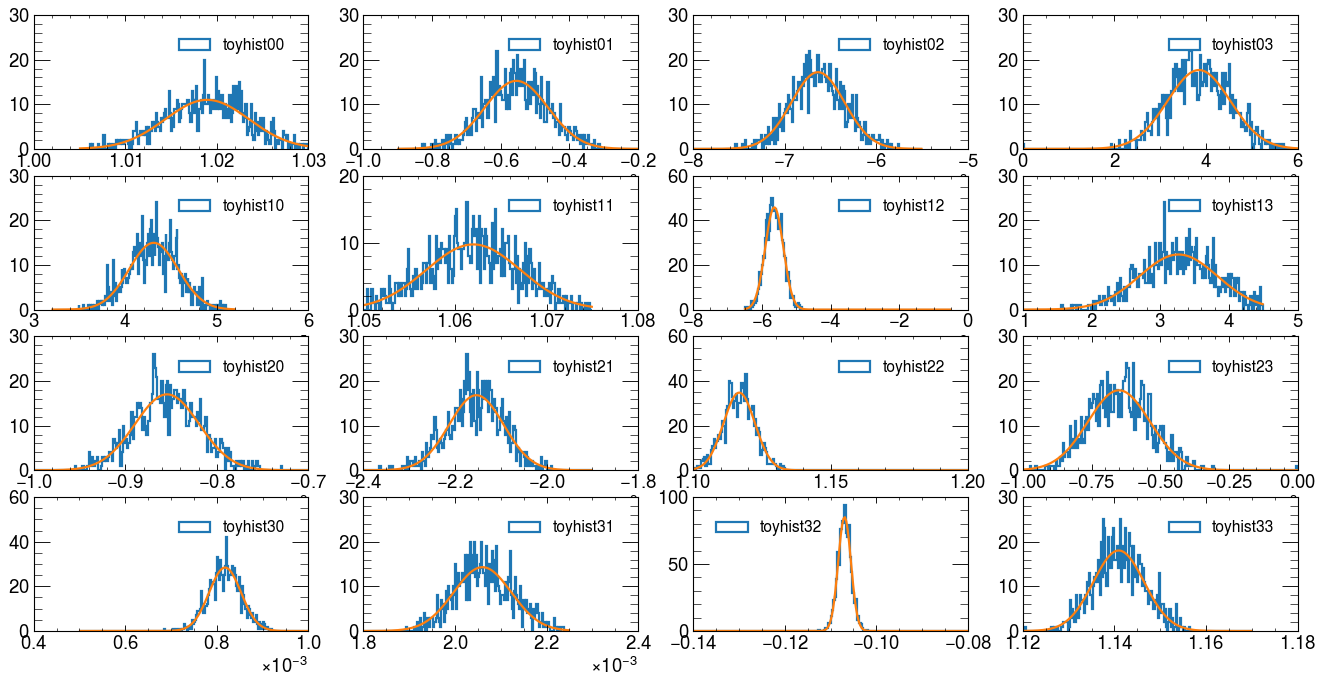

In [78]:
# Define gaussian function to fit to the toy distributions:



inverse_errors = np.zeros((4,4))
inverse_means = np.zeros((4,4))


fig = plt.figure(figsize=(20, 10),dpi=80)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
ax00 = plt.subplot(4,4,1)
ax01 = plt.subplot(4,4,2)
ax02 = plt.subplot(4,4,3)
ax03 = plt.subplot(4,4,4)

ax10 = plt.subplot(4,4,5)
ax11 = plt.subplot(4,4,6)
ax12 = plt.subplot(4,4,7)
ax13 = plt.subplot(4,4,8)

ax20 = plt.subplot(4,4,9)
ax21 = plt.subplot(4,4,10)
ax22 = plt.subplot(4,4,11)
ax23 = plt.subplot(4,4,12)

ax30 = plt.subplot(4,4,13)
ax31 = plt.subplot(4,4,14)
ax32 = plt.subplot(4,4,15)
ax33 = plt.subplot(4,4,16)

axes = [[ax00,ax01,ax02,ax03],
        [ax10,ax11,ax12,ax13],
        [ax20,ax21,ax22,ax23],
        [ax30,ax31,ax32,ax33]]

## IMPORTANT! Find suitable ranges to fit/plot gaussian distributions successfully!
ranges = [[(1.005,1.03)   ,(-0.0009,-0.0002), (-0.008,-0.0055), (-0.0000,0.000006)],
          [(0.000032,0.000052),(1.05,1.075)   , (-0.0065,-0.00049), (0.000001,0.0000045)],
          [(-0.01,-0.007),(-0.024,-0.019), (1.1,1.2)   , (-0.001,0)],
          [(0.0005,0.001),(0.0018,0.00225), (-0.14,-0.08), (1.12,1.17)]]


p0=[[[15,1.02,0.05],[20,-0.00055,0.00001],None, [26,0.000004,0.000001]],
    [[20,0.000044,0.000002],[20,1.062,0.004],None,[25,0.0000035,0.0000005]],
   [None,None,None,[28,-0.0007,0.00005]],
  [None, None, None, None]]

# Fill histograms for each inverted matrix coefficient:
for j in range(0,4,1):
    for k in range(0,4,1):
        
        # Diagonal and off-diagonal terms have different histogram ranges
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j,k,:],bins=200,range=ranges[j][k],  histtype='step', linewidth=2, label=f'toyhist{j}{k}')
        axes[j][k].legend()

        ## Guess initial parameters of the fit by taking random value from hist and std
        _p0 = [ntoy/10.,np.std(inverse_toys[j,k,:]),np.std(inverse_toys[j,k,:])]

        # Get the fitted curve
        h_mid = 0.5*(hedges[1:] + hedges[:-1]) #Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, maxfev=10000,p0=p0[j][k])
        h_fit = gauss(h_mid, *coeffs)
        
        axes[j][k].plot(h_mid, h_fit,label=f'Fit{j}{k}')

        inverse_means[j,k] = coeffs[1]
        inverse_errors[j,k] = abs(coeffs[2])

print(f"Erros for the inverse matrix:\n{inverse_errors}")

In [80]:
inverse_matrix1=np.linalg.inv(matrix)
inverse_matrix2=np.linalg.inv(matrix2)
print(f"The inverse matrix:\n{np.linalg.inv(matrix)}")
print(f"Erros for the inverse matrix:\n{inverse_errors}")

The inverse matrix:
[[ 1.01898954e+00 -5.53009827e-04 -6.60949390e-03  3.80770727e-06]
 [ 4.29975998e-05  1.06205837e+00 -5.63693761e-03  3.24742085e-06]
 [-8.51564572e-03 -2.15609522e-02  1.11639170e+00 -6.43149514e-04]
 [ 8.15567603e-04  2.06495370e-03 -1.06920007e-01  1.14093459e+00]]
Erros for the inverse matrix:
[[4.55500188e-03 9.22185542e-05 2.90170760e-04 6.87516523e-07]
 [2.67381041e-06 5.15913489e-03 2.63576244e-04 5.69119271e-07]
 [3.51557179e-04 5.95262262e-04 5.73035042e-03 1.13281975e-04]
 [3.49456111e-05 6.28873572e-05 1.39317910e-03 5.57067197e-03]]


# Exercise 2: Separate $t$- and $s$-channel contributions

Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The **electron** Monte Carlo sample incorporate contributions from $t$- and $s$-channels.
* Select/correct contributions producing $Z$ boson decays. (Hint: Which role does the $\cos(\theta)$ distribution play in separating $t$- and $s$-channels?)

0.5116313160533196
efficiency: 0.9563700929963279 0.043115838353785546


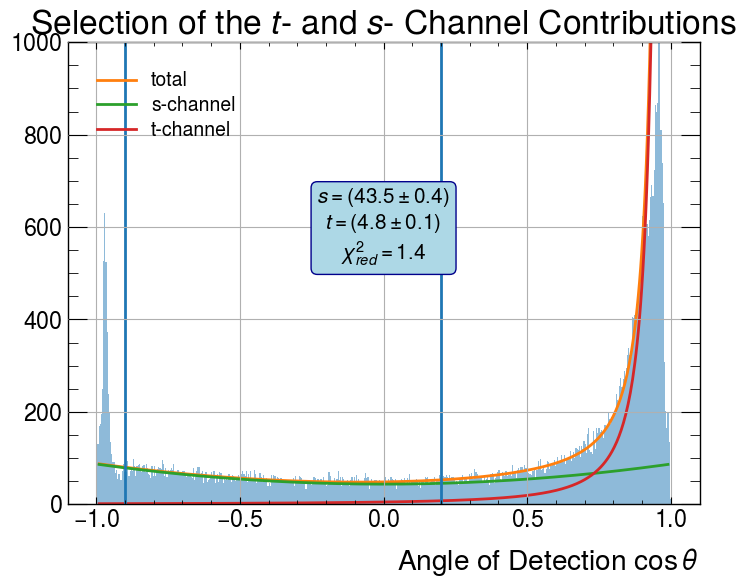

In [138]:


plt.figure()
plt.title(r'Selection of the $t$- and $s$- Channel Contributions')
plt.xlabel(r'Angle of Detection $\cos{\theta}$')
    
entries, bin_edges, patches=plt.hist(criteria[1][4], bins=500,range=(-1,1),alpha=0.5)
x=np.linspace(-0.99,0.99,len(entries))
    
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
#print(len(bin_middles), len(entries))
#plt.axvline(bin_middles[-15], color='red')
popt, pcov= curve_fit(f,bin_middles[17:-20],entries[17:-20],sigma=np.sqrt(entries[17:-20]),p0=[60.7,7.2], maxfev=2000)
plt.plot(x, f(x, *popt), label='total')
plt.plot(x, popt[0]*(1+x**2), label='s-channel')
plt.plot(x, popt[1]/(1-x)**2, label='t-channel')
         
         
redchi=redchi2(entries[17:-20],f(bin_middles[17:-20],*popt),np.sqrt(entries[17:-20]),2)


textstr = '\n'.join((
    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
    r'$\chi^2_{red}=%.1f$' % (redchi, )))

plt.text(0, 600, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')
u=1
l=-1

#efficiency=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/((popt[0]*((u+1/3*u**3)-(l+1/3*l**3)))+popt[1]*((1/(1-u))-(1/(1-l))))
#print(efficiency)
#print(entries)
efficiency_clean=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/(sum(entries)/250)
print(efficiency_clean)

u=0.2
l=-0.9
#wir werfen jetzt alle elektronen raus, die einen Winkel haben der Größer als blubb ist
#but von den ungecleanten Daten!!!!!!!!!!!!!!!
efficiency_clean2=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/(sum(entries[25:300])/250)
c1=((u+1/3*u**3)-(l+1/3*l**3))
c2=(1/(1-u)-1/(1-l))
efficiency_clean3=1/((1+popt[1]*c2/(popt[0]*c1)))
defficiency_clean3=np.sqrt((efficiency_clean3**2*c2)**2*pcov[1][1]+((efficiency_clean3**2*c1/(popt[0]))**2*pcov[0][0]))
plt.axvline(bin_edges[300])
plt.axvline(bin_edges[25])
#print(efficiency_clean2)
#print('efficiency:', efficiency_clean3,defficiency_clean3 )

#print(len(criteria[1][4]))
#print(sum(entries))
#b=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))
#print(b)
#plt.plot(x, f(x,6,7), color='red')
#print(criteria[1][4][:100])
plt.xlim(-1.1,1.1)
plt.ylim(0,1000)
plt.legend()
plt.grid()
u=0

l=-0.9
#wir werfen jetzt alle elektronen raus, die einen Winkel haben der Größer als blubb ist
##but von den ungecleanten Daten!!!!!!!!!!!!!!!
#efficiency_clean2=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/(sum(entries[25:300])/250)
efficiency_clean3=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/((popt[0]*((u+1/3*u**3)-(l+1/3*l**3))+popt[1]/(1-u)-popt[1]/(1-l)))
#recovering what we lose due to wrong assigment
#beta=len(cos_thet_ee)/sum(entries)

#dbeta=np.sqrt(len(cos_thet_ee)/sum(entries)**2+(len(cos_thet_ee)/sum(entries)**2)**2*sum(entries))

uu=1
ll=-1
a=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))
b=popt[0]*((uu+1/3*uu**3)-(ll+1/3*ll**3))
ratio=b/a
#plt.axvline(bin_edges[300])
#plt.axvline(bin_edges[25])
#print(efficiency_clean2)
print('efficiency:', efficiency_clean3,defficiency_clean3 )
#print('beta:', beta, dbeta)
#print(sum(entries),len(cos_thet_ee))

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [83]:
energy=[ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76]
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76]}
corr_hadr=[2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6]
corr_lep=[0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]


mean_energy, lumi,lumi_stat, lumi_sys, lumi_alll=CSV('daten_2.csv')

radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}

In [84]:
path_data = '/Users/sayed/OneDrive/Dokumente/GitHub/z0-precisionmeasurement/'
#path_mc = 'samples/data'
criteria2=[]
Datasets=[]
energy=[88.4,89.4,90.2,91.2,92,93,93.8]
for i in range(0, len(energy)):
    ### Open the file introducing file path
    file = uproot.open(path_data+'daten_2.root')
    ttree_name = 'myTTree'

    ### Print list of 'branches' of the TTree (i.e. list of variable names)
    file[ttree_name].keys()
    #print(file[ttree_name].keys())

    ## Load branches
    branches = file[ttree_name].arrays()

    ## Define an numpy array for 'Pcharged'
    Pcharged = 'Pcharged'
    NCharged='Ncharged'
    E_ecal='E_ecal'
    E_hcal='E_hcal'
    cos_thet='cos_thet'
    E_lep ='E_lep'
    pchar = ak.to_numpy(branches[Pcharged]) # See Docu (https://awkward-array.org/how-to-convert-numpy.html) for more conversions
    Nchar = ak.to_numpy(branches[NCharged])
    E_ecal = ak.to_numpy(branches[E_ecal])
    E_hcal = ak.to_numpy(branches[E_hcal])
    cos_thet =ak.to_numpy(branches[cos_thet])
    E_lep = ak.to_numpy(branches[E_lep])
   # print('vorher',pchar)
    
   # for j in [pchar]:#, Nchar, E_ecal, E_hcal, cos_thet]:
    pchar=np.where(np.around(E_lep,1)==energy[i]/2, pchar, 'hey')
    pchar= np.asarray(pchar[pchar != 'hey'], dtype=np.float64)
    Nchar=np.where(np.around(E_lep,1)==energy[i]/2, Nchar, 'hey')
    Nchar= np.asarray(Nchar[Nchar != 'hey'], dtype=np.float64)
    E_ecal=np.where(np.around(E_lep,1)==energy[i]/2, E_ecal, 'hey')
    E_ecal= np.asarray(E_ecal[E_ecal != 'hey'], dtype=np.float64)
    E_hcal=np.where(np.around(E_lep,1)==energy[i]/2, E_hcal, 'hey')
    E_hcal=np.asarray(E_hcal[E_hcal != 'hey'], dtype=np.float64)
    cos_thet=np.where(np.around(E_lep,1)==energy[i]/2, cos_thet, 'hey')
    cos_thet= np.asarray(cos_thet[cos_thet != 'hey'], dtype=np.float64)
    print(pchar)
        #print(j)
    #print(pchar)
   # print(energy[i])
   # print('nachher',pchar)
    criteria2.append([pchar, Nchar, E_ecal, E_hcal, cos_thet])
    #print(criteria2[i][0])

[ 23.020987  71.24515  118.150154 ...  18.943382   0.        48.27288 ]
[64.714584 50.664146 39.06396  ... 74.57058  51.337208 72.23964 ]
[36.807087 92.642204 54.018456 ... 52.84244  51.662834 93.75768 ]
[53.996334 42.25558  39.79855  ... 48.861664 58.32975  39.322407]
[  4.536599  46.009747  10.919354 ...   6.379793 110.50149   61.067482]
[51.80637  55.695053 65.909546 ... 72.60404  50.71825  38.55012 ]
[78.527306 46.733128 67.14702  ... 42.42682  62.29963  61.96474 ]


In [85]:
print(np.dot(np.array([1,efficiency_clean3,1,1]).T,matrix))
print(matrix[1],np.array([1,efficiency_clean3,1,1]).T )

[0.98889895 0.9193999  0.99023526 0.87702672]
[0.         0.94166436 0.0047547  0.        ] [1.         0.95637009 1.         1.        ]


In [94]:
hadron1=[]
ele1=[]
muon1=[]
tau1=[]
dhadron1=[]
dele1=[]
dmuon1=[]
dtau1=[]
hadron2=[]
ele2=[]
muon2=[]
tau2=[]
cos_thet_e=[]
cos_thet_muon=[]
e_s_channel=[]
s_channel_vec=np.array([1,ratio*efficiency_clean3, 1,1])
ds_channel_vec=np.array([0,ratio*np.sqrt((defficiency_clean3)**2),0,0])
matrix3=np.copy(matrix)
matrix3[1]=matrix[1]*efficiency_clean3
inverse_matrix1=np.linalg.inv(matrix)


for i in range(0, 7):
    #print(len(criteria2[i][0]))
    #print(len(criteria2[i][2]))
    num1, cos_thet_e_i, cos_thet_muon_i, e_s_channel_i=(count_particles_simulated(criteria2[i][0],criteria2[i][1],criteria2[i][2],criteria2[i][3],criteria2[i][4]))
    #print(num1[1])
    e_s_channel.append(e_s_channel_i)
    #print(len(e_s_channel[i]))
    num1[1]=len(e_s_channel[i])
    #print(num1[1])
    #print(num1)
    #### correct for t and s-channel
    cos_thet_e.append(cos_thet_e_i)
    
    cos_thet_muon.append(cos_thet_muon_i)
    num2=(particletest(criteria2[i][1],criteria2[i][0],criteria2[i][2],criteria2[i][3]))
    #print(num2)
    ####clean and pick s-channel electros out
    corr_vec=np.array([corr_hadr[i], corr_lep[i],corr_lep[i], corr_lep[i]])
    num1=np.array(num1)
    sigma_clean1=np.dot(inverse_matrix1,num1)*s_channel_vec/lumi[i]+corr_vec
    dsigma_clean1=np.sqrt((np.dot(error_matrix**2,num1**2)*s_channel_vec**2/lumi[i]**2)
        +(np.dot(inverse_matrix1**2,np.sqrt(num1)**2)*s_channel_vec**2/lumi[i]**2)
        +(np.dot(inverse_matrix1**2,num1**2)*ds_channel_vec**2/lumi[i]**2)
        +(lumi_stat[i]**2*np.dot(inverse_matrix1**2,num1**2)*s_channel_vec**2/lumi[i]**4))
    dsigma_clean1_sys=np.sqrt(np.abs((lumi_sys[i]*np.dot(inverse_matrix1**2,num1**2)))*s_channel_vec**2/lumi[i]**4)
    print(sigma_clean1, dsigma_clean1,  dsigma_clean1_sys)
    #print(lumi[i])
    sigma_clean2=np.dot(inverse_matrix2,np.array(num2))*s_channel_vec/lumi[i]+corr_vec
    #print(num_clean1)
    #print(mean_energy[i])
    hadron1.append(sigma_clean1[0])
    ele1.append(sigma_clean1[1])
    muon1.append(sigma_clean1[2])
    tau1.append(sigma_clean1[3])
    dhadron1.append(dsigma_clean1[0])
    dele1.append(dsigma_clean1[1])
    dmuon1.append(dsigma_clean1[2])
    dtau1.append(dsigma_clean1[3])
    hadron2.append(sigma_clean2[0])
    ele2.append(sigma_clean2[1])
    muon2.append(sigma_clean2[2])
    tau2.append(sigma_clean2[3])
    
cross_section1=np.array([hadron1, ele1,tau1,muon1])  
dcross_section1=np.array([dhadron1, dele1,dtau1,dmuon1])  
cross_section2=np.array([hadron2, ele2,tau2,muon2])


[7.47129713 0.32897976 0.36307698 0.26013642] [0.13046192 0.04080852 0.03121857 0.02476813] [0.02320919 0.00102666 0.00137552 0.00084277]
[14.39847742  0.69958388  0.62948386  0.60024225] [0.16395819 0.05457695 0.03480789 0.03243546] [0.03740888 0.00186832 0.00194637 0.0016452 ]
[26.18219413  1.28455935  1.07835902  1.09287907] [0.27068356 0.08755777 0.05185716 0.04981798] [0.07774227 0.00392252 0.0037647  0.00339054]
[40.92631482  1.73679545  1.7944236   1.73267387] [0.20137719 0.06730929 0.03124701 0.02801537] [0.0541644  0.00221326 0.0028016  0.00241406]
[29.05176865  1.1117456   1.19894041  1.30155344] [0.28097131 0.07522564 0.05095044 0.05073069] [0.08571838 0.00317751 0.00425329 0.0041561 ]
[13.92987017  0.41242654  0.64130511  0.52987018] [0.23185993 0.05609481 0.04902458 0.04367191] [0.06025747 0.00183272 0.00333655 0.00258741]
[8.37928652 0.31079751 0.33485137 0.35469094] [0.19095139 0.05460226 0.04020685 0.03952595] [0.04348197 0.00172298 0.0022173  0.00207752]


In [87]:
factor=1e-9*1e-28*(1.973e16)**2
factor=1/(1.973e-16)**2*1e-37

print(factor)

2.5688919007719265e-06


[-9.11853704e+01  5.84683508e+04  2.54459831e+00]
[40.94144433083713] [0.7134528645971329]
[ -90.98447326 2209.66133215    2.34184543]
[40.94144433083713, 1.8348721602691507] [0.7134528645971329, 0.23998034389647385]
[ -91.21168055 2331.68346284    2.46126217]
[40.94144433083713, 1.8348721602691507, 1.744150850205692] [0.7134528645971329, 0.23998034389647385, 0.1286313699168414]
[ -91.17504069 2488.25995527    2.51551895]
[40.94144433083713, 1.8348721602691507, 1.744150850205692, 1.7832808693425855] [0.7134528645971329, 0.23998034389647385, 0.1286313699168414, 0.14188746602949917]


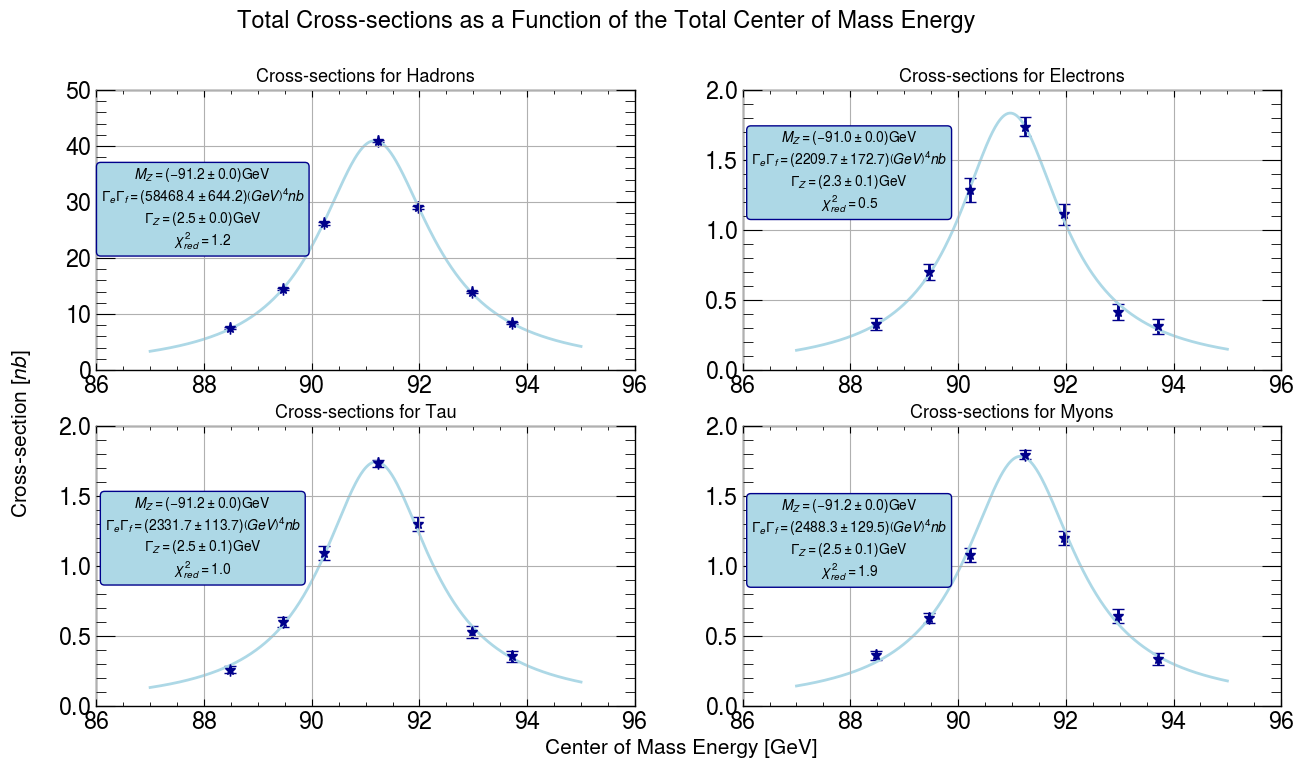

In [137]:



Mz=[]
dMz=[]
gamma_fe=[]
dgamma_fe=[]
gamma_z=[]
dgamma_z=[]
sigma_max=[]
dsigma_max=[]

energy_true=[88.47,89.46,90.22,91.22,91.97,92.96,93.8]
hohe=[300,15,13,20]
fig, ax = plt.subplots(figsize = (15, 8))
plt.suptitle('Total Cross-sections as a Function of the Total Center of Mass Energy',y=1.03, size=17)
fig.text(0.55, 0.1, r'Center of Mass Energy [GeV]', ha='center', fontsize=15)
fig.text(0.1025, 0.5, r'Cross-section [$nb$]', va='center', rotation='vertical', fontsize=15)
labels=['Cross-sections for Hadrons','Cross-sections for Electrons','Cross-sections for Tau', 'Cross-sections for Myons']
for i in [0,1,2,3]:
    plt.subplot(221+i)
    plt.title(labels[i], fontsize=13)
    plt.errorbar(mean_energy, cross_section1[i],dcross_section1[i],0, '*', color='darkblue', capsize=4,label=labels[i])
    popt1, pcov1=curve_fit(breit_wigner, mean_energy, cross_section1[i],sigma=dcross_section1[i], absolute_sigma=True, p0=[-91.18501194,252.75591492*230.92674034,2.54017013])
    #popt2, pcov2=curve_fit(breit_wigner, mean_energy, cross_section2[i])
    x=np.linspace(87, 95, 500)
    #plt.xlim(87.5,94)
    #plt.ylim(0,hohe[i]/5)
    plt.plot(x, breit_wigner(x, *popt1), color='lightblue')
    #plt.plot(x, breit_wigner(x, *popt2),color='pink')
    plt.grid()
    #plt.legend()
    
    
    redchi=redchi2(cross_section1[i],breit_wigner(mean_energy,*popt1), dcross_section1[i],3)


    textstr = '\n'.join((
        r'$M_Z=(%.1f \pm %.1f) $GeV' % (popt1[0],np.sqrt(pcov1[0][0]), ),
        r'$\Gamma_e \Gamma_f=(%.1f \pm %.1f) \left(GeV\right)^4nb$ ' % (popt1[1],np.sqrt(pcov1[1][1]), ),
        r'$\Gamma_Z=(%.1f \pm %.1f) $GeV ' % (popt1[2],np.sqrt(pcov1[2][2]), ),
        r'$\chi^2_{red}=%.1f$' % (redchi, )))

    plt.text(mean_energy[0]-0.5, cross_section1[i][2]*1.1, textstr, size=10,ha="center",
             va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')


    
    
    Mz.append(np.abs(popt1[0]))
    dMz.append(np.sqrt(np.abs(pcov1[0][0])))
    gamma_fe.append(np.abs(popt1[1]))
    dgamma_fe.append(np.sqrt(np.abs(pcov1[1][1])))
    gamma_z.append(np.abs(popt1[2]))
    dgamma_z.append(np.sqrt(np.abs(pcov1[2][2])))
    sigma_max.append(breit_wigner(popt1[0], *popt1))
    dsigma_max.append(12*np.pi*np.sqrt(pcov1[1][1]/(popt1[0]**2*popt1[2]**2)**2
                        +4*popt1[1]**2*pcov1[0][0]/(popt1[0]**3*popt1[2]**2)**2
                                       +4*popt1[1]**2*pcov1[2][2]/(popt1[0]**2*popt1[2]**3)**2))
    #plt.plot(x, breit_wigner(x, 91.18,0.0838**2,2.4952))
    print(popt1)
    print(sigma_max, dsigma_max)

[-91.18537037   0.15019887   2.54459832]
[0.00010517414470641187] [1.8327834490036552e-06]
[-9.09844733e+01  5.67638136e-03  2.34184551e+00]
[0.00010517414470641187, 4.713588128413666e-06] [1.8327834490036552e-06, 6.164829935539271e-07]
[-9.12116805e+01  5.98984165e-03  2.46126190e+00]
[0.00010517414470641187, 4.713588128413666e-06, 4.480535147881506e-06] [1.8327834490036552e-06, 6.164829935539271e-07, 3.304414485772183e-07]
[-9.11750406e+01  6.39206987e-03  2.51551872e+00]
[0.00010517414470641187, 4.713588128413666e-06, 4.480535147881506e-06, 4.58105593952491e-06] [1.8327834490036552e-06, 6.164829935539271e-07, 3.304414485772183e-07, 3.644928930190631e-07]


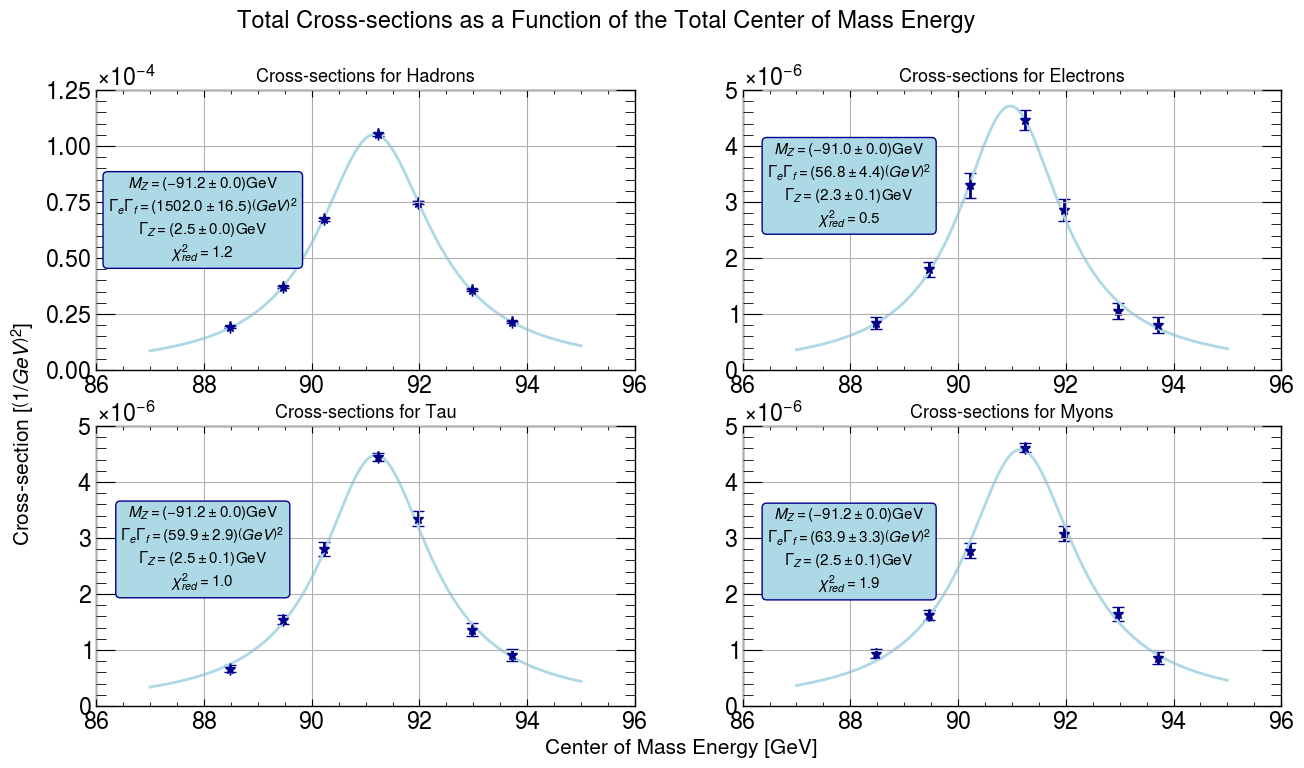

In [139]:


Mz=[]
dMz=[]
gamma_fe=[]
dgamma_fe=[]
gamma_z=[]
dgamma_z=[]
sigma_max=[]
dsigma_max=[]

energy_true=[88.47,89.46,90.22,91.22,91.97,92.96,93.8]
hohe=[300,15,13,20]
fig, ax = plt.subplots(figsize = (15, 8))
plt.suptitle('Total Cross-sections as a Function of the Total Center of Mass Energy',y=1.03, size=17)
fig.text(0.55, 0.1, r'Center of Mass Energy [GeV]', ha='center', fontsize=15)
fig.text(0.1025, 0.5, r'Cross-section [$\left(1/GeV\right)^2$]', va='center', rotation='vertical', fontsize=15)
labels=['Cross-sections for Hadrons','Cross-sections for Electrons','Cross-sections for Tau', 'Cross-sections for Myons']
for i in [0,1,2,3]:
    plt.subplot(221+i)
    plt.title(labels[i], fontsize=13)
    plt.errorbar(mean_energy, cross_section1[i]*factor,dcross_section1[i]*factor,0, '*', color='darkblue', capsize=4,label=labels[i])
    popt1, pcov1=curve_fit(breit_wigner, mean_energy, cross_section1[i]*factor,sigma=dcross_section1[i]*factor, absolute_sigma=True, p0=[-91.18501194,252.75591492*230.92674034,2.54017013])
    #popt2, pcov2=curve_fit(breit_wigner, mean_energy, cross_section2[i])
    x=np.linspace(87, 95, 500)
    #plt.xlim(87.5,94)
    #plt.ylim(0,hohe[i]/5)
    plt.plot(x, breit_wigner(x, *popt1), color='lightblue')
    #plt.plot(x, breit_wigner(x, *popt2),color='pink')
    plt.grid()
    #plt.legend()
    
    
    redchi=redchi2(cross_section1[i]*factor,breit_wigner(mean_energy,*popt1), dcross_section1[i]*factor,3)


    textstr = '\n'.join((
        r'$M_Z=(%.1f \pm %.1f) $GeV' % (popt1[0],np.sqrt(pcov1[0][0]), ),
        r'$\Gamma_e \Gamma_f=(%.1f \pm %.1f) \left(GeV\right)^2$ ' % (popt1[1]*1e4,np.sqrt(pcov1[1][1])*1e4, ),
        r'$\Gamma_Z=(%.1f \pm %.1f) $GeV ' % (popt1[2],np.sqrt(pcov1[2][2]), ),
        r'$\chi^2_{red}=%.1f$' % (redchi, )))

    plt.text(mean_energy[0]-0.5, cross_section1[i][2]*factor, textstr, size=11,ha="center",
             va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')


    
    
    Mz.append(np.abs(popt1[0]))
    dMz.append(np.sqrt(np.abs(pcov1[0][0])))
    gamma_fe.append(np.abs(popt1[1]))
    dgamma_fe.append(np.sqrt(np.abs(pcov1[1][1])))
    gamma_z.append(np.abs(popt1[2]))
    dgamma_z.append(np.sqrt(np.abs(pcov1[2][2])))
    sigma_max.append(breit_wigner(popt1[0], *popt1))
    dsigma_max.append(12*np.pi*np.sqrt(pcov1[1][1]/(popt1[0]**2*popt1[2]**2)**2
                        +4*popt1[1]**2*pcov1[0][0]/(popt1[0]**3*popt1[2]**2)**2
                                       +4*popt1[1]**2*pcov1[2][2]/(popt1[0]**2*popt1[2]**3)**2))
    #plt.plot(x, breit_wigner(x, 91.18,0.0838**2,2.4952))
    print(popt1)
    print(sigma_max, dsigma_max)
    

#beta was removed since it lead to wrong values, so the electrons which
#were not correctly registered by the detetor should indeed not be considered
#since they are probably mostly t-channel contributions, i.e. have very smaller theta values, such that the detector
#can not measure them
#(thats why the electron cross section is still as large as muon and taon cross section although we threw away half of the
#electrons
####################################
#note that changeing the integral limits changes the Z-mass for electrons, the smaller, the better
#it also changes the line width of all fermions, when trying to optimize the electron line width by making the
#intervall smaller, tau and muon line width worsen, thus one has to find a compromis

#moreover the number of leptons depends strongly on these intervals, such that enlarging the interval by a small amount
#yields two instead of three neutrinos

##################################
#we also tried to multiply the efficiency to the initial matrix, i.e. before inverting but this did not really yield 
#better results, it worsened the results for tau and muon but made them be less dependend of the cut interval for the
#t-s-channel seperation since here the actual electron entries were corrected in the matrix (before inverting), such that 
#the muon and tuon entries do not get effected this much....

######
#systematic errors: by cutting of an interval for s-t-channel, interference terms are neglected, this might lead to some
#deviation
#moreover half of the electrons are not measured correctly, this just leads to smaller number of overall electrons but
#well it worsens the cross-section.


In [140]:



gamma_e=np.sqrt(gamma_fe[1])
dgamma_e=dgamma_fe[1]/(2*gamma_e)
gammas=np.array([])
dgammas=np.array([])
for i in [0,1,2,3]:
    gammas=np.append(gammas, gamma_fe[i]/gamma_e)
    dgammas=np.append(dgammas, np.sqrt(dgamma_fe[i]**2/gamma_e**2+dgamma_e**2*gamma_fe[i]**2/gamma_e**4))
gammas[1]=gamma_e
dgammas[1]=dgamma_e
hadr_lit=(2*0.299+3*0.378)
lep_lit=83.8
print('partial decay width:')
print('-----------------------------------------------------')
print('hadrons:   literature value: %.2f GeV' %(hadr_lit))
print(r'measured:( %.2f  +/- %.2f) GeV, ttest:  %.1f' %(gammas[0],dgammas[0],ttest(gammas[0], dgammas[0], hadr_lit)))
print('leptons:   literature value: %.1f MeV'%(lep_lit))
print('electrons:( %.0f  +/- %.0f) MeV, ttest:  %.1f' %(gammas[1]*1000,dgammas[1]*1000,ttest(gammas[1]*1000, dgammas[1]*1000, lep_lit)))
print('taus:( %.0f  +/- %.0f) MeV, ttest:  %.1f' %(gammas[2]*1000,dgammas[2]*1000,ttest(gammas[2]*1000, dgammas[2]*1000, lep_lit)))
print('muons:( %.0f  +/- %.0f) MeV, ttest:  %.1f' %(gammas[3]*1000,dgammas[3]*1000,ttest(gammas[3]*1000, dgammas[3]*1000, lep_lit)))
print('-----------------------------------------------------')


sigma_max=np.array(sigma_max)
dsigma_max=np.array(dsigma_max)
gamma_z=np.array(gamma_z)
dgamma_z=np.array(dgamma_z)
gamma_z_weigh=np.sum(gamma_z*sigma_max)/np.sum(sigma_max)
dgamma_z_weigh=np.sqrt((np.sum(dgamma_z**2*sigma_max**2)+np.sum(gamma_z**2*dsigma_max**2))/np.sum(sigma_max)**2
                       +np.sum(gamma_z**2*sigma_max**2)*np.sum(dsigma_max**2)/np.sum(sigma_max)**4)
print('weighted total decay width: (%.1f +/- %.1f) GeV'%(gamma_z_weigh,dgamma_z_weigh))
print('total decay width obtained by hadrons: (%.1f +/- %.1f) GeV'%(gamma_z[0],dgamma_z[0]))
print('-----------------------------------------------------')
gamma_nu = 167.6/1000
gamma_nu_ges=gamma_z_weigh-np.sum(gammas)
dgamma_nu_ges=np.sqrt(dgamma_z_weigh**2+np.sum(dgammas**2))
print('partial width neutrinos, %.1f MeV' %(gamma_nu*1000))
print('measured: (%.1f +/- %.1f) MeV' %(gamma_nu_ges*1000/3, dgamma_nu_ges*1000/3))
number_nu=gamma_nu_ges/gamma_nu
dnumber_nu=np.sqrt(dgamma_nu_ges**2/gamma_nu**2)
print('number of lepton generations: (%.1f +/- %.1f) '%(number_nu, dnumber_nu))
print('-------------------------------------------------------')
print('using total decay width obtained by hadrons')
gamma_nu_ges=gamma_z[0]-np.sum(gammas)
dgamma_nu_ges=np.sqrt(dgamma_z[0]**2+np.sum(dgammas**2))
print('partial decay width neutrinos, %.1f' %(gamma_nu*1000))
print('measured: (%.1f +/- %.1f) MeV' %(gamma_nu_ges*1000/3, dgamma_nu_ges*1000/3))
number_nu=gamma_nu_ges/gamma_nu
dnumber_nu=np.sqrt(dgamma_nu_ges**2/gamma_nu**2)
print('number of lepton generations: (%.1f +/- %.1f) '%(number_nu, dnumber_nu))


partial decay width: [1.9935672525457566, 0.07534176374509047, 0.07950227543553468, 0.08484099057569948] [0.08093901190855837, 0.0029440773239070633, 0.004967398106614634, 0.005520710656533929]
-----------------------------------------------------


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

0.4826192234115668
0.9206060455404796
0.9582656207121154
beta: 2.022598870056497 0.028677009459922357
7434.0 15036


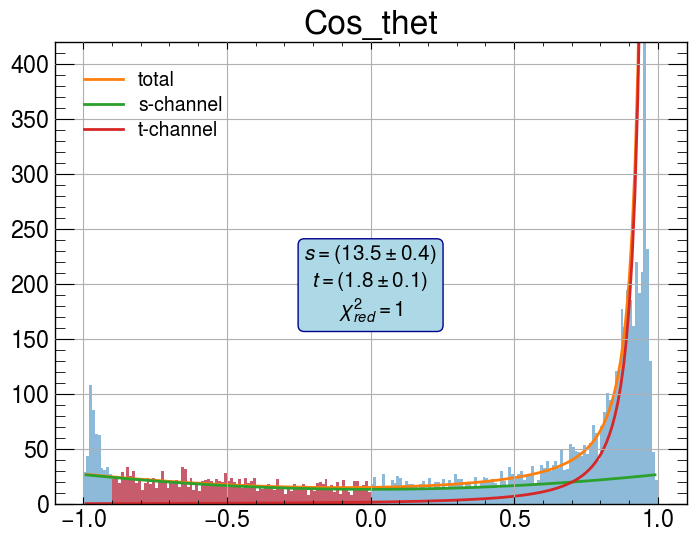

In [141]:
cos_thet_ee=np.concatenate((cos_thet_e[0],cos_thet_e[1],cos_thet_e[2],cos_thet_e[3],cos_thet_e[4],cos_thet_e[5],cos_thet_e[6]))
ee_s_channel=np.concatenate((e_s_channel[0],e_s_channel[1],e_s_channel[2],e_s_channel[3],e_s_channel[4],e_s_channel[5],e_s_channel[6]))
cos_thet_s_channel=[]
for i in range(0,len(ee_s_channel)):
    cos_thet_s_channel.append(ee_s_channel[i][4])



plt.figure()
plt.title('Cos_thet')

bins=200
entries, bin_edges, patches=plt.hist(cos_thet_ee, bins=bins,range=(-1,1),alpha=0.5)
entries2, bin_edges2, patches=plt.hist(cos_thet_s_channel, bins=200,range=(-1,1),alpha=0.5, color='red')
x=np.linspace(-0.99,0.99,len(entries))
    
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_middles2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])
#print(len(bin_middles), len(entries))
#plt.axvline(bin_middles[-15], color='red')
popt, pcov= curve_fit(f,bin_middles[17:-20],entries[17:-20],sigma=np.sqrt(entries[17:-20]),p0=[60.7,7.2], maxfev=2000)
plt.plot(x, f(x, *popt), label='total')
plt.plot(x, popt[0]*(1+x**2), label='s-channel')
plt.plot(x, popt[1]/(1-x)**2, label='t-channel')         
         


redchi=redchi2(entries[17:-20],f(bin_middles[17:-20],*popt),np.sqrt(entries[17:-20]))


textstr = '\n'.join((
    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
    r'$\chi^2_{red}=%.0f$' % (redchi, )))

plt.text(0, 200, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')



plt.xlim(-1.1,1.1)
plt.ylim(0,420)
plt.legend()
plt.grid()
#print(len(cos_thet_ee),sum(entries))
u=0.95
l=-0.95
#the reason why we calculate a ratio is that we only plot  half of the particles since the rest is set to 999, to regain this info we multiply the ratio to all
efficiency=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/((popt[0]*((u+1/3*u**3)-(l+1/3*l**3)))+popt[1]*((1/(1-u))-(1/(1-l))))
#print(efficiency) #it doesnt know that its throwing particles out
#print(entries)
u=1
l=-1
efficiency_dirty=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))*bins/2/sum(entries) #Einheit von Achse in Bineinheit umrechnen
print(efficiency_dirty)
u=-0.2

l=-0.9
#wir werfen jetzt alle elektronen raus, die einen Winkel haben der Größer als blubb ist
##but von den ungecleanten Daten!!!!!!!!!!!!!!!
#efficiency_clean2=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/(sum(entries[25:300])/250)
efficiency_clean3=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))/((popt[0]*((u+1/3*u**3)-(l+1/3*l**3))+popt[1]/(1-u)-popt[1]/(1-l)))
#recovering what we lose due to wrong assigment
beta=len(cos_thet_ee)/sum(entries)

dbeta=np.sqrt(len(cos_thet_ee)/sum(entries)**2+(len(cos_thet_ee)/sum(entries)**2)**2*sum(entries))

uu=1
ll=-1
a=popt[0]*((u+1/3*u**3)-(l+1/3*l**3))
b=popt[0]*((uu+1/3*uu**3)-(ll+1/3*ll**3))
ratio=b/a
#plt.axvline(bin_edges[300])
#plt.axvline(bin_edges[25])
print(efficiency_clean2)
print(efficiency_clean3)
print('beta:', beta, dbeta)
print(sum(entries),len(cos_thet_ee))


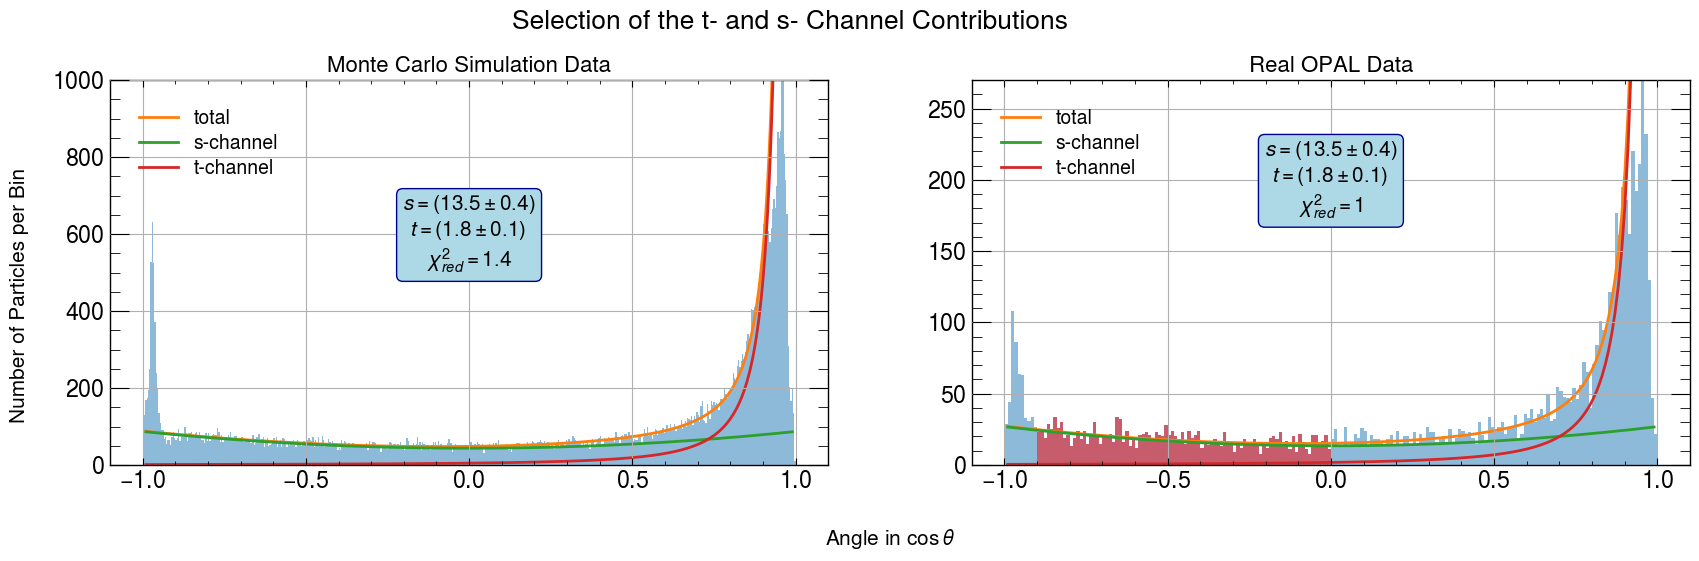

In [162]:
fig, ax = plt.subplots(figsize = (20, 5))
plt.suptitle('Selection of the t- and s- Channel Contributions',y=1.07, size=19)
fig.text(0.55, 0, r'Angle in $\cos{\theta}$', ha='center', fontsize=15)
fig.text(0.11, 0.5, r'Number of Particles per Bin', va='center', rotation='vertical', fontsize=15)


plt.subplot(121)
entries1, bin_edges1, patches1=plt.hist(criteria[1][4], bins=500,range=(-1,1),alpha=0.5)
x=np.linspace(-0.99,0.99,len(entries1))
    
bin_middles1 = 0.5 * (bin_edges1[1:] + bin_edges1[:-1])
popt1, pcov1= curve_fit(f,bin_middles1[17:-20],entries1[17:-20],sigma=np.sqrt(entries1[17:-20]),p0=[60.7,7.2], maxfev=2000)
plt.plot(x, f(x, *popt1), label='total')
plt.plot(x, popt1[0]*(1+x**2), label='s-channel')
plt.plot(x, popt1[1]/(1-x)**2, label='t-channel')
plt.grid()
plt.legend()
plt.title('Monte Carlo Simulation Data', fontsize=16)
plt.xlim(-1.1,1.1)

         
         
redchi1=redchi2(entries1[17:-20],f(bin_middles1[17:-20],*popt1),np.sqrt(entries1[17:-20]),2)


textstr = '\n'.join((
    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
    r'$\chi^2_{red}=%.1f$' % (redchi1, )))

plt.text(0, 600, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')

plt.ylim(0,1000)
plt.subplot(122)
bins=200
entries, bin_edges, patches=plt.hist(cos_thet_ee, bins=bins,range=(-1,1),alpha=0.5)
entries2, bin_edges2, patches=plt.hist(cos_thet_s_channel, bins=200,range=(-1,1),alpha=0.5, color='red')
x=np.linspace(-0.99,0.99,len(entries))
    
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_middles2 = 0.5 * (bin_edges2[1:] + bin_edges2[:-1])

popt, pcov= curve_fit(f,bin_middles[17:-20],entries[17:-20],sigma=np.sqrt(entries[17:-20]),p0=[60.7,7.2], maxfev=2000)
plt.plot(x, f(x, *popt), label='total')
plt.plot(x, popt[0]*(1+x**2), label='s-channel')
plt.plot(x, popt[1]/(1-x)**2, label='t-channel')         
         

redchi=redchi2(entries[17:-20],f(bin_middles[17:-20],*popt),np.sqrt(entries[17:-20]))


textstr = '\n'.join((
    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
    r'$\chi^2_{red}=%.0f$' % (redchi, )))

plt.text(0, 200, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')


plt.title('Real OPAL Data', fontsize=16)
plt.xlim(-1.1,1.1)
plt.ylim(0,270)
plt.legend()
plt.grid()

In [ ]:
#pick electrons with right angle




In [ ]:
#if we would consider the ratio which we obtained by the simulation
#we would have to multiply the first efficiecy matrix row with this ratio
#since here we considered the actual number of electrons, thus, when applying the cuts
#and obtaining our particle number vector we can not just multiply the electron number with the ratio
#because this number might include some other particles obtained by miscounting plus the other entries of this vector
#might also include electrons due to miscounting. We, therefore, have to multiply the whole electron
#row of our efficiency matrix with the ratio since this matrix entry includes the ''actual electrons''
#By multiplying the ratio to this row one takes account of all electrons even the misasigned ones
#Whereas the ratio obtained above is calculated using the electrons obtained by cutting,
#thus it contains the correctly and falsely assigned electrons
#this ratio can thus directly be multiplied to the electron number obtained by cutting and then the matrix can be multplied
#
#In the sinulation part the matrix contains the actual number of particles, thus the electron row describes all
#actual electrons and these have to be corrected
#here our vector is cutted and contains false information we have to repair this by multiplying with the
#inverse of the efficiency matrix after doing this and obtaining the true electron number, we can multiply the ''true'' N
#by the ratio 


#no wait, dont we then just have to do it like that in both cases
#the final numbers, I mean after correction are the ''true number''

#but the point is which data we used to obtain the ratios
###################################################################################################
#############here#####################################
#in the first case we use the right electrons
#in the second case the uncorrected ones, thus we have to multiply the ratio to the uncorrected number 
#but this means we correct the s-channel the wrong data with the ratio that we obtained from the wrong data
#so we assumed the wrong data to be give the actual electrons, but that is false

#What should we have done than?
#we cannot correct the angular data, since we dont know which entries are the actual electron entries, the efficiency matrix
#can only correct particle numbers, it does not care about the entries it only corrects the overall number.

#Thus, all in all, it would make more sense to use the ratio obtained from the simulation, since it is a ratio calculated
#using the true electrons not the wrong uncorrected ones

#the remaing question is, how to multiply this ratio 

#it would make sense to multiply it to the corrected number
#multiplying it to the electron matrix entry, would this make sense 
#shouldnt we first remove the electrons from the non-electron entries of the vector by using the efficiency matrix
#How would it make sense to correct the electron entry of the matrix
#we would correct the amount  we subtract away from the other vector entries,
#but shouldnt we just subtract all electrons, t- and s-channel and not only s-channel
#we should first correct the vector considering both channels and afterwards pick the s-channel

#or wait, it would also work this way
# wait multplying the first entry or multiplying the final electron number gives the same

#but it would not make sense to multiply the ratio to the uncorrected electron number

#I see

#and for the first method, its the same, we dont want to calculate the s-channels for the wrong number
#but only after correction

In [ ]:
num_clean1=np.dot(inverse_matrix1,np.array(num1[0]))
num_clean2=np.dot(inverse_matrix2,np.array(num2[0]))
print(len(criteria2[0][0])-sum(num_clean1), len(criteria2[0][0])-sum(num_clean2))

# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

In [ ]:
radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76]}
correction=[0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]

## Simulation part

In [ ]:
plt.figure()
plt.title('Cos_thet')

    
entries, bin_edges, patches=plt.hist(criteria[3][4], bins=200,range=(-1,1), label='muon',alpha=0.5)
x=np.linspace(-0.99,0.99,len(entries))
    
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
#print(len(bin_middles), len(entries))
z=100   # 250 350
plt.axvline(bin_middles[z], color='red')
N_b = sum(entries[:z])
N_f=sum(entries[z:])
Asym = (N_f-N_b)/(N_f+N_b)
d_Asym= np.sqrt(N_f/(N_f+N_b)**2+ ((N_f-N_b)/(N_f+N_b)**2)**2*N_f+N_b/(N_f+N_b)**2+ ((N_f-N_b)/(N_f+N_b)**2)**2*N_b)
print('Aymmetry factor:',Asym,'+/-', d_Asym)     
print(sum(entries), len(criteria[3][4]), max(criteria[3][4]))
print(np.sqrt(2*N_f/(N_f+N_b)**2))
#0.004508867439297285

#textstr = '\n'.join((
#    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
#    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
#    r'$\chi^2_{red}=%.0f$' % (redchi, )))

#plt.text(0, 600, textstr, size=15,ha="center",
#         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')

#plt.plot(x, f(x,6,7), color='red')
    
plt.xlim(-1.1,1.1)
#plt.ylim(0,300)
plt.legend()
plt.grid()
#mean energy abchecken 

## OPAL data

In [ ]:
plt.figure()
plt.title('Cos_thet')
cos_thet_mm=np.concatenate((cos_thet_muon[0],cos_thet_muon[1],cos_thet_muon[2],cos_thet_muon[3],cos_thet_muon[4],cos_thet_muon[5],cos_thet_muon[6]))

bins=100   
Asym=[]
dAsym=[]
for i in range(0,7):
    entries, bin_edges, patches=plt.hist(cos_thet_muon[i], bins=bins,range=(-1,1), label='muon',alpha=0.5)
    x=np.linspace(-0.99,0.99,len(entries))

    bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    #print(len(bin_middles), len(entries))
    z=int(bins/2)   # 250 350
    plt.axvline(bin_middles[z], color='red')
    N_b = sum(entries[:z])
    N_f=sum(entries[z:])
    
    Asym.append((N_f-N_b)/(N_f+N_b))
    dAsym.append(np.sqrt(N_f/(N_f+N_b)**2+ ((N_f-N_b)/(N_f+N_b)**2)**2*N_f+N_b/(N_f+N_b)**2
                          + ((N_f-N_b)/(N_f+N_b)**2)**2*N_b))
    print(np.sqrt(2*N_f/(N_f+N_b)**2), (N_f-N_b)/(N_f+N_b))
    #0.004508867439297285

    #textstr = '\n'.join((
    #    r'$s=(%.1f \pm %.1f) $' % (popt[0],np.sqrt(pcov[0][0]), ),
    #    r'$t=(%.1f \pm %.1f) $ ' % (popt[1],np.sqrt(pcov[1][1]), ),
    #    r'$\chi^2_{red}=%.0f$' % (redchi, )))

    #plt.text(0, 600, textstr, size=15,ha="center",
    #         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')

    #plt.plot(x, f(x,6,7), color='red')

    plt.xlim(-1,1)
    #plt.ylim(0,300)
    plt.legend()
    plt.grid()
print('Aymmetry factor:',Asym,'+/-', dAsym) 
#[-0.20634920634920634, -0.017341040462427744, -0.13821138211382114, 0.005714285714285714, 0.0038314176245210726, 0.30386740331491713, 0.07462686567164178

In [ ]:

Asym_corr=(np.array(Asym)+np.array(correction))
plt.errorbar(mean_energy, Asym_corr,dAsym,0,'*')
popt_lin, pcov_lin=curve_fit(lin, mean_energy,Asym_corr, sigma=dAsym)#, absolute_sigma=True)
x=np.linspace(87, 94, 500)
plt.plot(x, lin(x, *popt_lin))
redchi_lin=redchi2(Asym_corr, lin(mean_energy, *popt_lin), dAsym)
textstr = '\n'.join((
r'$a=(%.2f \pm %.2f) $' % (popt_lin[0],np.sqrt(pcov_lin[0][0]), ),
    r'$b=(%.1f \pm %.1f) $ ' % (popt_lin[1],np.sqrt(pcov_lin[1][1]), ),
    r'$\chi^2_{red}=%.1f$' % (redchi, )))

plt.text(88, 0.2, textstr, size=15,ha="center",
         va="center",bbox=dict(boxstyle="round",facecolor='lightblue', edgecolor='darkblue', ), color='black')

In [ ]:
print(mean_energy)

In [ ]:
sintheta2=1/4*(1-np.sqrt(popt_lin[0]/3))

dsintheta2=1/8/np.sqrt(popt_lin[0]/3)*1/3*np.sqrt(pcov_lin[0][0])
angle_lit=0.23122
dangle_lit=0.00004
print('Weinberg angle literature value')
print('----------------------------')
print('sintheta^2= 0.23122(4)')
print('----------------------------')
print('Forward-backward asymmetry and Weinberg angle obtained from linear fit slope:')
print('------------------------------------------------')
print('A_FB=(%.2f +/- %.2f)' %(popt_lin[0], np.sqrt(pcov_lin[0][0]))) 
print('sintheta^2= (%.2f +/- %.2f),   ttest: %.1f' %(sintheta2,dsintheta2,ttest(sintheta2,dsintheta2,angle_lit, dangle_lit)))
print('------------------------------------------')

sintheta2_res=1/4*(1-np.sqrt(Asym_corr[3]/3))

dsintheta2_res=1/8/np.sqrt(Asym_corr[3]/3)*1/3*np.sqrt(dAsym[3])
print('Forward-backward asymmetry and Weinberg angle obtained at resonance energy:')
print('------------------------------------------------')
print('A_FB=(%.2f +/- %.2f)'%(Asym_corr[3], dAsym[3])) 
print('sintheta^2= (%.2f +/- %.2f),   ttest: %.1f' %(sintheta2_res,dsintheta2_res,ttest(sintheta2_res,dsintheta2_res,angle_lit, dangle_lit)))
#maybe the latter is more reasonable since at the resonance we have the largest cross section thus the most events
#this value therefore has to be weighted more
#in order to do so one could again calculate the weighted mean for muons (using the crossectio obtained for muons):
print('--------------------------')
Asym_weigh=np.sum(np.array(Asym_corr)*cross_section1[3])/np.sum(cross_section1[3])
dAsym_weigh=np.sqrt((np.sum(np.array(dAsym)**2*cross_section1[3]**2)
                     +np.sum(np.array(Asym_corr)**2*dcross_section1[3]**2))/np.sum(cross_section1[3])**2
                       +np.sum(cross_section1[3]**2)*np.sum(np.array(Asym_corr)**2*cross_section1[3]**2)
                            /np.sum(cross_section1[3])**4)

sintheta2_weigh=1/4*(1-np.sqrt(Asym_weigh/3))
dsintheta2_weigh=1/8/np.sqrt(Asym_weigh/3)*1/3*np.sqrt(dAsym_weigh)
print('Forward-backward asymmetry and Weinberg angle obtained by weighted asymmetry factor:')
print('------------------------------------------------')
print('A_FB=(%.2f +/- %.2f)'%(Asym_weigh, dAsym_weigh)) 
print('sintheta^2= (%.2f +/- %.2f),   ttest: %.1f' %(sintheta2_weigh,dsintheta2_weigh,ttest(sintheta2_weigh,dsintheta2_weigh,angle_lit, dangle_lit)))
                
print('--------------------------')

# Exercise 4: Tests on lepton universality¶

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

In [ ]:
ratio_sigma=sigma_max/sigma_max[0]
dratio_sigma=np.sqrt((dsigma_max/sigma_max[0])**2+(sigma_max/sigma_max[0]**2*dsigma_max[0])**2)
print('ratio of the hadrons and leptons cross sections:')
print('-------------------------------------------------------')
print('e/h: (%.0f +/- %.0f) %%'%(ratio_sigma[1]*100, dratio_sigma[1]*100))
print('tau/h: (%.1f +/- %.1f) %%'%(ratio_sigma[2]*100, dratio_sigma[2]*100))
print('muon/h: (%.1f +/- %.1f)%%'%(ratio_sigma[3]*100, dratio_sigma[3]*100))
#ratio_branch= np.mean([gammas[1],gammas[2],gammas[3]])/gammas[0]
ratio_branch=gammas/gamma_z_weigh
dratio_branch=np.sqrt((dgammas/gamma_z_weigh)**2+(dgamma_z*np.array(gammas)/gamma_z_weigh**2)**2)
ratio_ratio=ratio_branch/ratio_branch[0]
dratio_ratio=np.sqrt((dratio_branch/ratio_branch[0])**2+(dratio_branch[0]*ratio_branch/ratio_branch[0]**2)**2)
print('-------------------------------------------------------')
print('branching ratios:')
print('-------------------------------------------------------')
print('hadrons: (%.1f +/- %.1f) %%'%(ratio_branch[0]*100, dratio_branch[0]*100))
print('electrons: (%.1f +/- %.1f) %%'%(ratio_branch[1]*100, dratio_branch[1]*100))
print('taus: (%.1f +/- %.1f) %%'%(ratio_branch[2]*100, dratio_branch[2]*100))
print('muons: (%.1f +/- %.1f)%%'%(ratio_branch[3]*100, dratio_branch[3]*100))
print('-------------------------------------------------------')
print('ratios of branching ratios in comparison to ratios of cross sections:')
print('-------------------------------------------------------')
print('e/h: (%.1f +/- %.1f) %%'%(ratio_ratio[1]*100, dratio_ratio[1]*100),',     ttest: %.1f'% (ttest(ratio_ratio[1], dratio_ratio[1],ratio_sigma[1], dratio_sigma[1]) ))
print('tau/h: (%.1f +/- %.1f) %%'%(ratio_ratio[2]*100, dratio_ratio[2]*100),',     ttest: %.1f'% (ttest(ratio_ratio[2], dratio_ratio[2],ratio_sigma[2], dratio_sigma[2]) ))
print('muon/h: (%.1f +/- %.1f)%%'%(ratio_ratio[3]*100, dratio_ratio[3]*100),',     ttest: %.1f'% (ttest(ratio_ratio[3], dratio_ratio[3],ratio_sigma[3], dratio_sigma[3]) ))
print('-------------------------------------------------------')
